In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

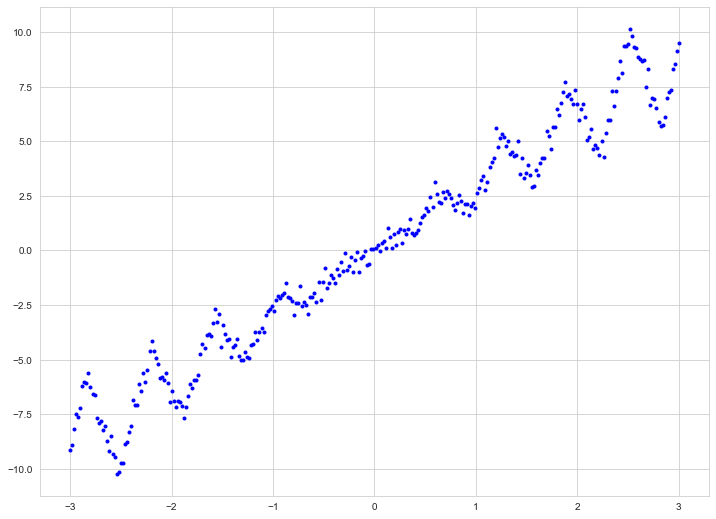

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y,ax, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    ax.axis(axes)
    #ax.xlabel("$x_1$", fontsize=18)
    #if ylabel:
        #ax.ylabel(ylabel, fontsize=18, rotation=0)

    ax.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [6]:
# разобьем выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

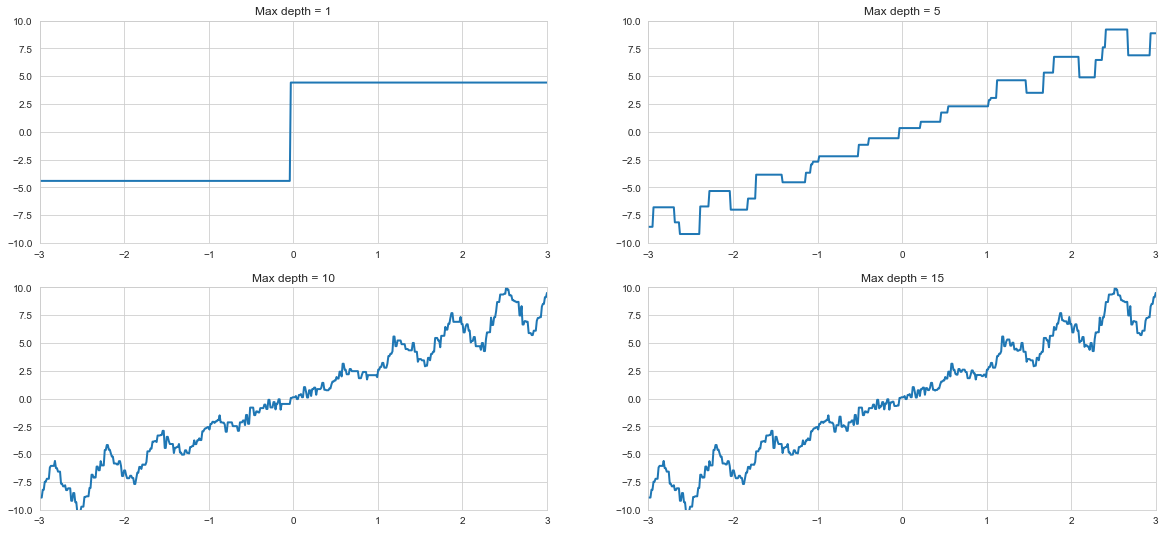

In [7]:
# Нарисуем графики для деревьев глубиной 1, 5, 10 и 15.
# Как видно 10 и 15 уже ничем не отличаются
fig, ax = plt.subplots(2,2, figsize=(20,9))

clf = DecisionTreeRegressor(max_depth=1)
clf.fit(X_train, y_train)
ax[0,0].set_title('Max depth = 1')
plot_regression_predictions(clf, X_test, y_test,ax[0,0])

clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X_train, y_train)
ax[0,1].set_title('Max depth = 5')
plot_regression_predictions(clf, X_test, y_test,ax[0,1])

clf = DecisionTreeRegressor(max_depth=10)
clf.fit(X_train, y_train)
ax[1,0].set_title('Max depth = 10')
plot_regression_predictions(clf, X_test, y_test,ax[1,0])

clf = DecisionTreeRegressor(max_depth=15)
clf.fit(X_train, y_train)
ax[1,1].set_title('Max depth = 15')
plot_regression_predictions(clf, X_test, y_test,ax[1,1])

In [8]:
# Проверим метрики
from sklearn.metrics import explained_variance_score

for i in range(10,16):
    clf = DecisionTreeRegressor(max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    var = explained_variance_score(y_train, y_pred)
    print('Variance score on max depth',i,'is',var)

Variance score on max depth 10 is 0.9998950303038796
Variance score on max depth 11 is 0.9999931775692242
Variance score on max depth 12 is 0.9999999999805655
Variance score on max depth 13 is 1.0
Variance score on max depth 14 is 1.0
Variance score on max depth 15 is 1.0


In [9]:
from sklearn.metrics import r2_score

for i in range(10,16):
    clf = DecisionTreeRegressor(max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    var = r2_score(y_train, y_pred)
    print('R2 score on max depth',i,'is',var)

R2 score on max depth 10 is 0.9998950303038796
R2 score on max depth 11 is 0.9999931775692242
R2 score on max depth 12 is 0.9999999999805655
R2 score on max depth 13 is 1.0
R2 score on max depth 14 is 1.0
R2 score on max depth 15 is 1.0


In [10]:
from sklearn.metrics import mean_squared_error

for i in range(10,16):
    clf = DecisionTreeRegressor(max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    var = mean_squared_error(y_train, y_pred)
    print('MSE on max depth',i,'is',var)

MSE on max depth 10 is 0.00279469970794371
MSE on max depth 11 is 0.0001816395207484066
MSE on max depth 12 is 5.174197402595589e-10
MSE on max depth 13 is 0.0
MSE on max depth 14 is 0.0
MSE on max depth 15 is 0.0


In [11]:
# Судя по метрикам, начиная с глубины 13 модель идеальна.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [12]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [13]:
# Создадим функцию для рассчета мю.
import math 

def foo(p,j=101):
    a = []
    for i in range(51,j):
        x = math.comb(j, i) * pow(p, i) * pow(1-p, j-i)
        a.append(x)
    result = sum(a)
    return result

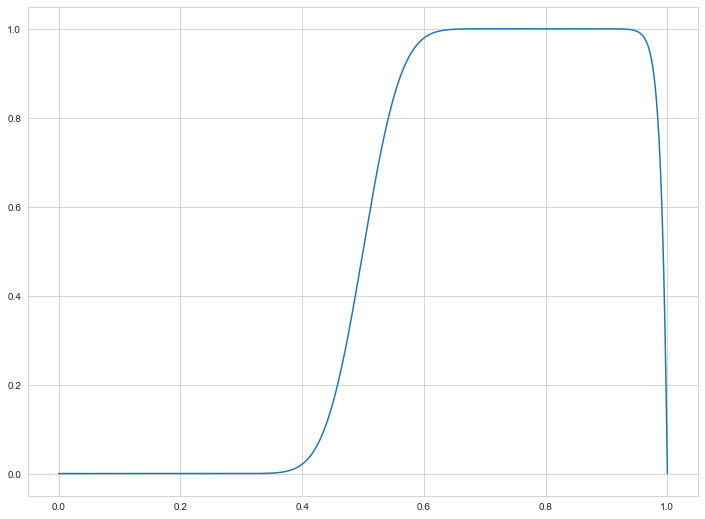

In [14]:
# Построим график зависимости. Как видно, начиная с р=0,6, вероятность уже почти 1.
x = np.linspace(0, 1, 1000)
y = foo(x)
plt.plot(x, y)

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

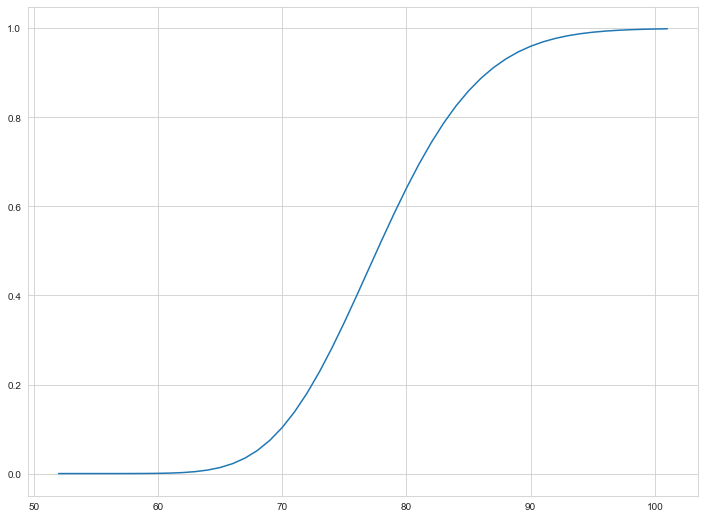

In [16]:
# Построим график зависимости при р=0,65 и число моделей от 51 до 101
# Мы видим, что начиная с 90 моделей вероятность стремится к 1. 
x = np.arange(52,102)
y = []
for m in x:
    y.append(foo(p=0.65,j=m))
plt.plot(x, y)



Опишите ваши наблюдения:

* Вероятность должна быть выше 0.6
* Число моделей должно быть выше 90

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [17]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
           
            feat_ids_by_tree_step = np.random.choice(np.arange(X.shape[1]), 
                                                   size=self.max_features, 
                                                   replace=False)
            self.feat_ids_by_tree.append(feat_ids_by_tree_step)
           
            pseudo_slice = np.random.choice(np.arange(len(X)), 
                                          size=len(X), replace=True)

            clf = DecisionTreeClassifier(max_depth=self.max_depth,
                                       max_features=self.max_features,
                                       random_state=self.random_state+i)
            self.trees.append(clf.fit(X[pseudo_slice][:, feat_ids_by_tree_step], 
                                    y[pseudo_slice]))

            return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        y_pred_storage = []

        for feats, tree in zip(self.feat_ids_by_tree, self.trees):
            y_pred_storage.append(tree.predict_proba(X[:, feats]))

        return np.average(y_pred_storage, axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [18]:
def plot_decision_boundary(clf, X, y,ax, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        ax.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    ax.axis(axes)
    #plt.xlabel(r"$x_1$", fontsize=18)
    #plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

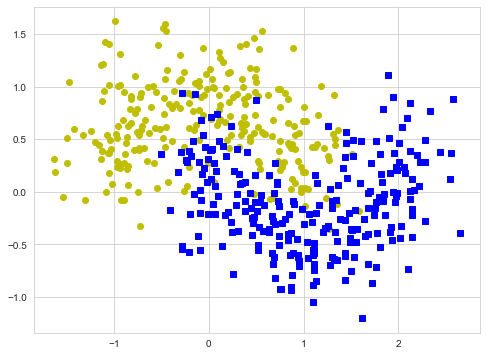

In [19]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [20]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##


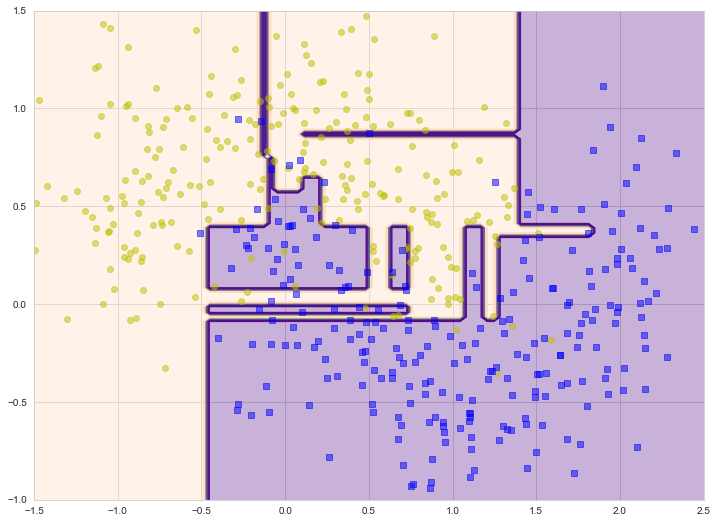

In [21]:
test_clf = RandomForestClassifierCustom(max_depth=8, max_features=X.shape[1], 
                                     random_state=SEED,n_estimators=10)
test_clf.fit(X, y)

plot_decision_boundary(test_clf, X, y,ax=plt)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [22]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [23]:
# Сначала подберем наилучшие параметры на основании метрик.
# Мы видим, что n_estimator не влияет на roc_auc. А лучшая max depth на 6 и 8. 
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
for i in range(1,11):
    for j in range(1,11):
        test_clf = RandomForestClassifierCustom(max_depth=i, max_features=X.shape[1], 
                                     random_state=SEED,n_estimators=j)
        test_clf.fit(X_train, y_train)
        y_pred = test_clf.predict(X_test)
        RAC = roc_auc_score(y_test, y_pred)
        print('For max depth',i,'and n_estimators',j,'roc_auc is',RAC)


For max depth 1 and n_estimators 1 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 2 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 3 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 4 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 5 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 6 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 7 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 8 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 9 roc_auc is 0.7764358561460011
For max depth 1 and n_estimators 10 roc_auc is 0.7764358561460011
For max depth 2 and n_estimators 1 roc_auc is 0.8620504562533547
For max depth 2 and n_estimators 2 roc_auc is 0.8620504562533547
For max depth 2 and n_estimators 3 roc_auc is 0.8620504562533547
For max depth 2 and n_estimators 4 roc_auc is 0.8620504562533547
For max depth 2 and n_estimators 5 roc_auc is 0.8620504562533547
For max depth 2 and n_es

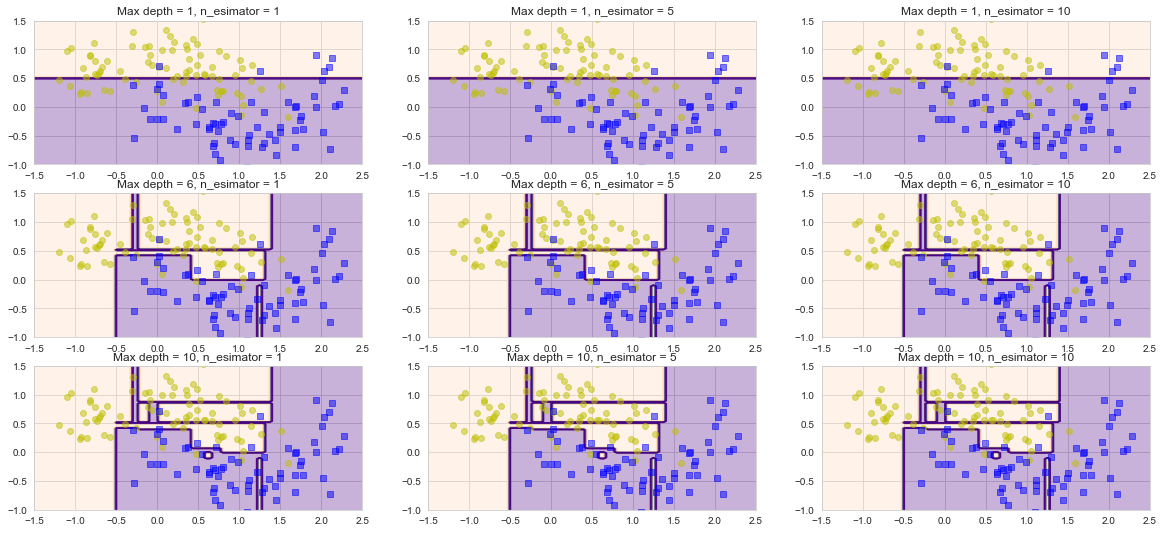

In [24]:
fig, ax = plt.subplots(3,3, figsize=(20,9))

test_clf = RandomForestClassifierCustom(max_depth=1, max_features=X.shape[1], random_state=SEED,n_estimators=1)
test_clf.fit(X_train, y_train)
ax[0,0].set_title('Max depth = 1, n_esimator = 1')
plot_decision_boundary(test_clf, X_test, y_test, ax[0,0])

test_clf = RandomForestClassifierCustom(max_depth=1, max_features=X.shape[1], random_state=SEED,n_estimators=5)
test_clf.fit(X_train, y_train)
ax[0,1].set_title('Max depth = 1, n_esimator = 5')
plot_decision_boundary(test_clf, X_test, y_test, ax[0,1])

test_clf = RandomForestClassifierCustom(max_depth=1, max_features=X.shape[1], random_state=SEED,n_estimators=10)
test_clf.fit(X_train, y_train)
ax[0,2].set_title('Max depth = 1, n_esimator = 10')
plot_decision_boundary(test_clf, X_test, y_test, ax[0,2])

test_clf = RandomForestClassifierCustom(max_depth=6, max_features=X.shape[1], random_state=SEED,n_estimators=1)
test_clf.fit(X_train, y_train)
ax[1,0].set_title('Max depth = 6, n_esimator = 1')
plot_decision_boundary(test_clf, X_test, y_test, ax[1,0])

test_clf = RandomForestClassifierCustom(max_depth=6, max_features=X.shape[1], random_state=SEED,n_estimators=5)
test_clf.fit(X_train, y_train)
ax[1,1].set_title('Max depth = 6, n_esimator = 5')
plot_decision_boundary(test_clf, X_test, y_test, ax[1,1])

test_clf = RandomForestClassifierCustom(max_depth=6, max_features=X.shape[1], random_state=SEED,n_estimators=10)
test_clf.fit(X_train, y_train)
ax[1,2].set_title('Max depth = 6, n_esimator = 10')
plot_decision_boundary(test_clf, X_test, y_test, ax[1,2])

test_clf = RandomForestClassifierCustom(max_depth=10, max_features=X.shape[1], random_state=SEED,n_estimators=1)
test_clf.fit(X_train, y_train)
ax[2,0].set_title('Max depth = 10, n_esimator = 1')
plot_decision_boundary(test_clf, X_test, y_test, ax[2,0])

test_clf = RandomForestClassifierCustom(max_depth=10, max_features=X.shape[1], random_state=SEED,n_estimators=5)
test_clf.fit(X_train, y_train)
ax[2,1].set_title('Max depth = 10, n_esimator = 5')
plot_decision_boundary(test_clf, X_test, y_test, ax[2,1])

test_clf = RandomForestClassifierCustom(max_depth=10, max_features=X.shape[1], random_state=SEED,n_estimators=10)
test_clf.fit(X_train, y_train)
ax[2,2].set_title('Max depth = 10, n_esimator = 10')
plot_decision_boundary(test_clf, X_test, y_test, ax[2,2])



#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [25]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [26]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [28]:
df = pd.DataFrame()

for i in range(1, 31,1):
    rf = RandomForestClassifier(max_features=i)
    rf.fit(X_train, y_train)
    df[f'{i}'] = base_model_pair_correlation(rf, X_test)

Text(0.5, 1.0, 'Dependance on max feature number')

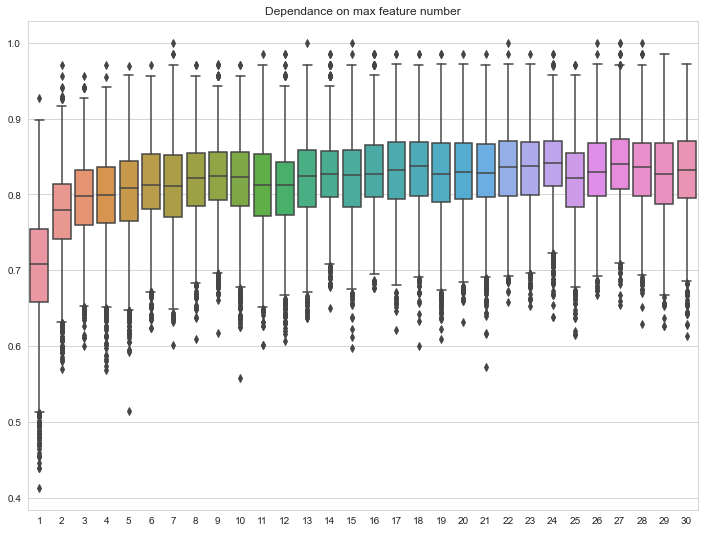

In [29]:
sns.boxplot(data=df).set_title("Dependance on max feature number")

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [30]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [31]:
df = pd.DataFrame()

for i in range(1, 31,1):
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    df[f'{i}'] = base_model_pair_correlation(rf, X_test)

Text(0.5, 1.0, 'Dependance on max depth number')

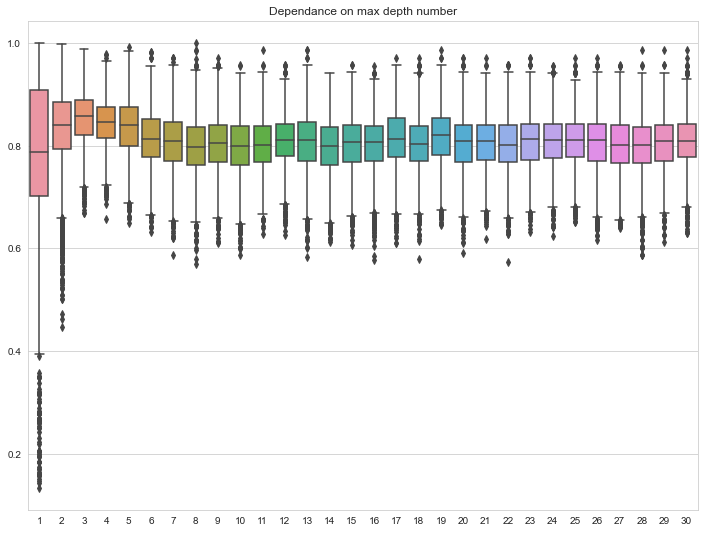

In [32]:
sns.boxplot(data=df).set_title("Dependance on max depth number")

Опишите ваши наблюдения:

* При увеличении значения max feature мы видим рост корреляции с определенным выходом на плато после 10
* При увеличении значения max depth идет сначала рост, потом снижение и достигается плато начиная с 9.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [33]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [34]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [35]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [36]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=[("DT", dt), ("RF", rf), 
                                            ("ETC", etc), ("KNN", knn), 
                                            ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
                                            ("CAT", cat), ("LGBM", lgbm), 
                                            ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
                                            ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)], voting='hard')
voting_soft = VotingClassifier(estimators=[("DT", dt), ("RF", rf), 
                                            ("ETC", etc), ("KNN", knn), 
                                            ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
                                            ("CAT", cat), ("LGBM", lgbm), 
                                            ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
                                            ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)], voting='soft')

base_models.append(('voting_hard', voting_hard))
base_models.append(('voting_soft', voting_soft))

for name, model in base_models:
    model.fit(X_train, y_train)

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8379629629629629
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [37]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [38]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [39]:
# Вычислим корреляцию
df = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)


In [40]:
# Найдем для каких ансамблей значение корреляции больше 0.05
score = []
for i in range(0,78):
    score.append(df[i][2])

    #find max value in list
max_value = [i for i in score if i >= 0.95]
max_value

max_index = []
for i in max_value:
    max_index.append(score.index(i))

max_index

for i in max_index:
    print(df[i][0])

RandomForestClassifier(n_estimators=50, random_state=111)
RandomForestClassifier(n_estimators=50, random_state=111)
RandomForestClassifier(n_estimators=50, random_state=111)
RandomForestClassifier(n_estimators=50, random_state=111)
RandomForestClassifier(n_estimators=50, random_state=111)
RandomForestClassifier(n_estimators=50, random_state=111)
ExtraTreesClassifier(random_state=111)
ExtraTreesClassifier(random_state=111)
ExtraTreesClassifier(random_state=111)
ExtraTreesClassifier(random_state=111)
ExtraTreesClassifier(random_state=111)
ExtraTreesClassifier(random_state=111)
ExtraTreesClassifier(random_state=111)
SVC(kernel='linear', probability=True, random_state=111)
LGBMClassifier(random_state=111)
LGBMClassifier(random_state=111)


In [41]:
# Попробуем удались сильно коррелирующие модели
# За основу возьмем voting_soft т.к. у нее самый высокий score = 0.8455110375195781 
# Таким образом мы повысили score до 0.8586993970714901

voting_soft_reduced = VotingClassifier(estimators=[
                                            ("KNN", knn), 
                                            ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
                                            ("DT", dt), 
                                            ("XGB", xgb), 
                                            ("LR", lr), ("NB", nb)], voting='soft')


scores = cross_val_score(voting_soft_reduced, X_train, y_train, cv=3, scoring="f1")
print(f"{model.__class__.__name__}: {scores.mean()}")

VotingClassifier: 0.8586993970714901


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [42]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [43]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [44]:
# Изменим значение столбцов на boolean type
for i in range(3333):
    if data["Int'l Plan"][i] == 'yes':
        data["Int'l Plan"][i] = 1
    else:
        data["Int'l Plan"][i] = 0
data["Int'l Plan"] = pd.to_numeric(data["Int'l Plan"]) 
data["Int'l Plan"] = data["Int'l Plan"].astype('bool')
for i in range(3333):
    if data["VMail Plan"][i] == 'yes':
        data["VMail Plan"][i] = 1
    else:
        data["VMail Plan"][i] = 0
data["VMail Plan"] = pd.to_numeric(data["VMail Plan"]) 
data["VMail Plan"] = data["VMail Plan"].astype('bool')
for i in range(3333):
    if data['Churn?'][i] == 'True.':
        data['Churn?'][i] = 1
    else:
        data['Churn?'][i] = 0
data['Churn?'] = pd.to_numeric(data['Churn?']) 
data['Churn?'] = data['Churn?'].astype('bool')

In [45]:
X = data.drop(['State', 'Area Code', 'Phone', 'Churn?'], axis=1)
y = data['Churn?']

In [46]:
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

In [47]:
# Построим оптимизацию для XGBClassifier
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X, y, cv=3, scoring='roc_auc'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1)

In [48]:
# Мы нашли гиперпараметры для XGBClassifier
optimizer.maximize(init_points=3, n_iter=7)
print(optimizer.max['params']);optimizer.max['target'] 

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.924     | 2.085     | 0.7231    | 3.001     | 372.1     |
| 2         | 0.9226    | 0.7338    | 0.1014    | 4.304     | 411.0     |
| 3         | 0.9184    | 1.984     | 0.5434    | 5.934     | 716.7     |
| 4         | 0.9188    | 4.09      | 0.7356    | 3.26      | 271.8     |
| 5         | 0.9178    | 4.696     | 0.5208    | 3.679     | 512.1     |
| 6         | 0.9111    | 1.536     | 0.7392    | 4.154     | 372.5     |
| 7         | 0.9111    | 0.106     | 0.8098    | 9.754     | 731.9     |
| 8         | 0.9199    | 1.822     | 0.03217   | 4.067     | 974.4     |
| 9         | 0.9118    | 3.903     | 0.9582    | 3.117     | 271.9     |
| 10        | 0.9156    | 4.906     | 0.2777    | 8.661     | 501.9     |
{'gamma': 2.08511002351287, 'learning_rate': 0.7231212485077365, 'max_depth': 3.000800623721414, 'n_estimators':

0.9240100250626565

In [49]:
# Построим оптимизацию для CatBoostClassifier

pbounds = {'learning_rate': (0.01, 1.0),'n_estimators': (100, 1000),'depth': (2,10)}

def сatboost_hyper_param(learning_rate,n_estimators,depth):

    depth = int(depth)
    n_estimators = int(n_estimators)

    clf = CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        loss_function='Logloss')
    return np.mean(cross_val_score(clf, X, y, cv=3, scoring='roc_auc'))

optimizer = BayesianOptimization(
    f=сatboost_hyper_param,
    pbounds=pbounds,
    random_state=1)

In [50]:
# Подберем лучшие параметры для CatBoostClassifier
optimizer.maximize(init_points=3, n_iter=7)
print(optimizer.max['params']);optimizer.max['target'] 

|   iter    |  target   |   depth   | learni... | n_esti... |
-------------------------------------------------------------
0:	learn: 0.3822530	total: 2.51ms	remaining: 249ms
1:	learn: 0.2955020	total: 5.12ms	remaining: 251ms
2:	learn: 0.2364129	total: 7.29ms	remaining: 236ms
3:	learn: 0.2039450	total: 9.58ms	remaining: 230ms
4:	learn: 0.1915182	total: 11.7ms	remaining: 223ms
5:	learn: 0.1853748	total: 14ms	remaining: 219ms
6:	learn: 0.1716380	total: 16.3ms	remaining: 217ms
7:	learn: 0.1666485	total: 18.6ms	remaining: 213ms
8:	learn: 0.1592200	total: 20.9ms	remaining: 212ms
9:	learn: 0.1543642	total: 23.2ms	remaining: 209ms
10:	learn: 0.1527106	total: 25.6ms	remaining: 207ms
11:	learn: 0.1485932	total: 27.7ms	remaining: 203ms
12:	learn: 0.1445089	total: 30ms	remaining: 201ms
13:	learn: 0.1443775	total: 32.1ms	remaining: 197ms
14:	learn: 0.1393758	total: 34.2ms	remaining: 194ms
15:	learn: 0.1373935	total: 36.2ms	remaining: 190ms
16:	learn: 0.1372475	total: 38.2ms	remaining: 186ms
17:	le

68:	learn: 0.0839772	total: 155ms	remaining: 69.7ms
69:	learn: 0.0829230	total: 158ms	remaining: 67.6ms
70:	learn: 0.0828720	total: 160ms	remaining: 65.3ms
71:	learn: 0.0826529	total: 162ms	remaining: 63ms
72:	learn: 0.0825157	total: 164ms	remaining: 60.8ms
73:	learn: 0.0819890	total: 167ms	remaining: 58.5ms
74:	learn: 0.0785745	total: 169ms	remaining: 56.4ms
75:	learn: 0.0783425	total: 172ms	remaining: 54.2ms
76:	learn: 0.0769280	total: 174ms	remaining: 51.9ms
77:	learn: 0.0758689	total: 177ms	remaining: 49.8ms
78:	learn: 0.0754070	total: 179ms	remaining: 47.5ms
79:	learn: 0.0748708	total: 181ms	remaining: 45.2ms
80:	learn: 0.0738418	total: 183ms	remaining: 43ms
81:	learn: 0.0736561	total: 186ms	remaining: 40.8ms
82:	learn: 0.0736068	total: 189ms	remaining: 38.6ms
83:	learn: 0.0717767	total: 191ms	remaining: 36.4ms
84:	learn: 0.0709843	total: 193ms	remaining: 34.1ms
85:	learn: 0.0696398	total: 195ms	remaining: 31.8ms
86:	learn: 0.0690966	total: 198ms	remaining: 29.5ms
87:	learn: 0.068

49:	learn: 0.1620960	total: 85.8ms	remaining: 228ms
50:	learn: 0.1606634	total: 87.7ms	remaining: 227ms
51:	learn: 0.1593401	total: 89.3ms	remaining: 225ms
52:	learn: 0.1583452	total: 91ms	remaining: 223ms
53:	learn: 0.1573083	total: 92.5ms	remaining: 221ms
54:	learn: 0.1564076	total: 94ms	remaining: 219ms
55:	learn: 0.1547074	total: 95.5ms	remaining: 217ms
56:	learn: 0.1538310	total: 97.1ms	remaining: 215ms
57:	learn: 0.1528494	total: 98.7ms	remaining: 213ms
58:	learn: 0.1522848	total: 100ms	remaining: 211ms
59:	learn: 0.1509775	total: 102ms	remaining: 209ms
60:	learn: 0.1501214	total: 104ms	remaining: 207ms
61:	learn: 0.1490659	total: 105ms	remaining: 205ms
62:	learn: 0.1484418	total: 107ms	remaining: 204ms
63:	learn: 0.1484115	total: 108ms	remaining: 202ms
64:	learn: 0.1478512	total: 110ms	remaining: 200ms
65:	learn: 0.1467133	total: 111ms	remaining: 198ms
66:	learn: 0.1461557	total: 113ms	remaining: 196ms
67:	learn: 0.1456306	total: 115ms	remaining: 194ms
68:	learn: 0.1455797	total

83:	learn: 0.1554451	total: 157ms	remaining: 185ms
84:	learn: 0.1552898	total: 159ms	remaining: 184ms
85:	learn: 0.1546185	total: 161ms	remaining: 182ms
86:	learn: 0.1545232	total: 162ms	remaining: 179ms
87:	learn: 0.1544110	total: 164ms	remaining: 177ms
88:	learn: 0.1543865	total: 166ms	remaining: 175ms
89:	learn: 0.1535959	total: 167ms	remaining: 173ms
90:	learn: 0.1535258	total: 169ms	remaining: 171ms
91:	learn: 0.1530409	total: 170ms	remaining: 168ms
92:	learn: 0.1529749	total: 172ms	remaining: 166ms
93:	learn: 0.1522203	total: 174ms	remaining: 165ms
94:	learn: 0.1513008	total: 175ms	remaining: 163ms
95:	learn: 0.1507837	total: 177ms	remaining: 160ms
96:	learn: 0.1502596	total: 179ms	remaining: 158ms
97:	learn: 0.1501290	total: 180ms	remaining: 156ms
98:	learn: 0.1500163	total: 182ms	remaining: 155ms
99:	learn: 0.1494580	total: 184ms	remaining: 152ms
100:	learn: 0.1490239	total: 185ms	remaining: 150ms
101:	learn: 0.1487096	total: 187ms	remaining: 149ms
102:	learn: 0.1486710	total: 

80:	learn: 0.1493394	total: 161ms	remaining: 202ms
81:	learn: 0.1492966	total: 163ms	remaining: 200ms
82:	learn: 0.1487734	total: 164ms	remaining: 198ms
83:	learn: 0.1486659	total: 166ms	remaining: 195ms
84:	learn: 0.1483032	total: 167ms	remaining: 193ms
85:	learn: 0.1474895	total: 169ms	remaining: 190ms
86:	learn: 0.1472855	total: 170ms	remaining: 188ms
87:	learn: 0.1472286	total: 172ms	remaining: 186ms
88:	learn: 0.1465440	total: 174ms	remaining: 183ms
89:	learn: 0.1462359	total: 175ms	remaining: 181ms
90:	learn: 0.1461810	total: 177ms	remaining: 178ms
91:	learn: 0.1461237	total: 178ms	remaining: 176ms
92:	learn: 0.1460212	total: 179ms	remaining: 174ms
93:	learn: 0.1459826	total: 181ms	remaining: 171ms
94:	learn: 0.1459319	total: 183ms	remaining: 169ms
95:	learn: 0.1452009	total: 184ms	remaining: 167ms
96:	learn: 0.1450808	total: 186ms	remaining: 165ms
97:	learn: 0.1449614	total: 187ms	remaining: 162ms
98:	learn: 0.1443584	total: 189ms	remaining: 160ms
99:	learn: 0.1443156	total: 190

77:	learn: 0.0892950	total: 240ms	remaining: 1.17s
78:	learn: 0.0889148	total: 243ms	remaining: 1.16s
79:	learn: 0.0878067	total: 246ms	remaining: 1.16s
80:	learn: 0.0877870	total: 248ms	remaining: 1.15s
81:	learn: 0.0868751	total: 251ms	remaining: 1.15s
82:	learn: 0.0862834	total: 254ms	remaining: 1.14s
83:	learn: 0.0855638	total: 257ms	remaining: 1.14s
84:	learn: 0.0849687	total: 260ms	remaining: 1.14s
85:	learn: 0.0841271	total: 263ms	remaining: 1.13s
86:	learn: 0.0834940	total: 266ms	remaining: 1.13s
87:	learn: 0.0822249	total: 268ms	remaining: 1.12s
88:	learn: 0.0815798	total: 271ms	remaining: 1.12s
89:	learn: 0.0807142	total: 274ms	remaining: 1.12s
90:	learn: 0.0802543	total: 276ms	remaining: 1.11s
91:	learn: 0.0794186	total: 279ms	remaining: 1.11s
92:	learn: 0.0788638	total: 282ms	remaining: 1.1s
93:	learn: 0.0780981	total: 284ms	remaining: 1.1s
94:	learn: 0.0777036	total: 287ms	remaining: 1.09s
95:	learn: 0.0767008	total: 290ms	remaining: 1.09s
96:	learn: 0.0757835	total: 293ms

262:	learn: 0.0266820	total: 744ms	remaining: 549ms
263:	learn: 0.0264525	total: 747ms	remaining: 546ms
264:	learn: 0.0263346	total: 750ms	remaining: 543ms
265:	learn: 0.0263305	total: 753ms	remaining: 541ms
266:	learn: 0.0260790	total: 756ms	remaining: 538ms
267:	learn: 0.0260761	total: 759ms	remaining: 535ms
268:	learn: 0.0259301	total: 762ms	remaining: 532ms
269:	learn: 0.0257671	total: 765ms	remaining: 530ms
270:	learn: 0.0256298	total: 768ms	remaining: 527ms
271:	learn: 0.0255787	total: 771ms	remaining: 524ms
272:	learn: 0.0253011	total: 774ms	remaining: 522ms
273:	learn: 0.0252984	total: 776ms	remaining: 519ms
274:	learn: 0.0251313	total: 780ms	remaining: 516ms
275:	learn: 0.0251250	total: 782ms	remaining: 513ms
276:	learn: 0.0249861	total: 785ms	remaining: 510ms
277:	learn: 0.0248192	total: 788ms	remaining: 507ms
278:	learn: 0.0246576	total: 790ms	remaining: 504ms
279:	learn: 0.0245233	total: 793ms	remaining: 501ms
280:	learn: 0.0243206	total: 796ms	remaining: 498ms
281:	learn: 

448:	learn: 0.0116061	total: 1.25s	remaining: 22.3ms
449:	learn: 0.0115929	total: 1.25s	remaining: 19.5ms
450:	learn: 0.0115920	total: 1.26s	remaining: 16.7ms
451:	learn: 0.0115839	total: 1.26s	remaining: 13.9ms
452:	learn: 0.0115499	total: 1.26s	remaining: 11.1ms
453:	learn: 0.0115461	total: 1.26s	remaining: 8.36ms
454:	learn: 0.0115047	total: 1.27s	remaining: 5.57ms
455:	learn: 0.0114224	total: 1.27s	remaining: 2.79ms
456:	learn: 0.0113854	total: 1.27s	remaining: 0us
0:	learn: 0.4677187	total: 7.45ms	remaining: 3.4s
1:	learn: 0.3540571	total: 11.1ms	remaining: 2.53s
2:	learn: 0.3127337	total: 14.7ms	remaining: 2.23s
3:	learn: 0.2823040	total: 18.4ms	remaining: 2.09s
4:	learn: 0.2633885	total: 22ms	remaining: 1.99s
5:	learn: 0.2524769	total: 25.6ms	remaining: 1.92s
6:	learn: 0.2425898	total: 29.2ms	remaining: 1.88s
7:	learn: 0.2357699	total: 32.7ms	remaining: 1.83s
8:	learn: 0.2154698	total: 35.7ms	remaining: 1.78s
9:	learn: 0.2094204	total: 38.4ms	remaining: 1.71s
10:	learn: 0.197597

186:	learn: 0.0465015	total: 517ms	remaining: 747ms
187:	learn: 0.0458183	total: 520ms	remaining: 744ms
188:	learn: 0.0455170	total: 523ms	remaining: 742ms
189:	learn: 0.0451426	total: 526ms	remaining: 739ms
190:	learn: 0.0449785	total: 529ms	remaining: 737ms
191:	learn: 0.0447030	total: 532ms	remaining: 734ms
192:	learn: 0.0444663	total: 535ms	remaining: 731ms
193:	learn: 0.0444050	total: 537ms	remaining: 728ms
194:	learn: 0.0441018	total: 540ms	remaining: 726ms
195:	learn: 0.0438991	total: 544ms	remaining: 725ms
196:	learn: 0.0438839	total: 547ms	remaining: 722ms
197:	learn: 0.0433864	total: 550ms	remaining: 719ms
198:	learn: 0.0429965	total: 552ms	remaining: 716ms
199:	learn: 0.0427923	total: 555ms	remaining: 713ms
200:	learn: 0.0426346	total: 558ms	remaining: 710ms
201:	learn: 0.0426206	total: 560ms	remaining: 707ms
202:	learn: 0.0422264	total: 563ms	remaining: 704ms
203:	learn: 0.0419098	total: 565ms	remaining: 701ms
204:	learn: 0.0418184	total: 568ms	remaining: 698ms
205:	learn: 

363:	learn: 0.0167568	total: 1.02s	remaining: 260ms
364:	learn: 0.0166410	total: 1.02s	remaining: 257ms
365:	learn: 0.0165932	total: 1.02s	remaining: 255ms
366:	learn: 0.0165465	total: 1.03s	remaining: 252ms
367:	learn: 0.0164519	total: 1.03s	remaining: 249ms
368:	learn: 0.0164037	total: 1.03s	remaining: 246ms
369:	learn: 0.0163881	total: 1.03s	remaining: 244ms
370:	learn: 0.0162978	total: 1.04s	remaining: 241ms
371:	learn: 0.0162080	total: 1.04s	remaining: 238ms
372:	learn: 0.0160704	total: 1.04s	remaining: 235ms
373:	learn: 0.0160196	total: 1.05s	remaining: 233ms
374:	learn: 0.0159576	total: 1.05s	remaining: 230ms
375:	learn: 0.0158915	total: 1.05s	remaining: 227ms
376:	learn: 0.0158558	total: 1.06s	remaining: 224ms
377:	learn: 0.0157997	total: 1.06s	remaining: 221ms
378:	learn: 0.0157216	total: 1.06s	remaining: 218ms
379:	learn: 0.0156276	total: 1.06s	remaining: 216ms
380:	learn: 0.0155839	total: 1.07s	remaining: 213ms
381:	learn: 0.0155582	total: 1.07s	remaining: 210ms
382:	learn: 

120:	learn: 0.0668096	total: 339ms	remaining: 943ms
121:	learn: 0.0664126	total: 343ms	remaining: 941ms
122:	learn: 0.0658097	total: 345ms	remaining: 938ms
123:	learn: 0.0655222	total: 348ms	remaining: 935ms
124:	learn: 0.0652876	total: 351ms	remaining: 932ms
125:	learn: 0.0650390	total: 354ms	remaining: 929ms
126:	learn: 0.0641373	total: 357ms	remaining: 927ms
127:	learn: 0.0634941	total: 360ms	remaining: 925ms
128:	learn: 0.0629990	total: 363ms	remaining: 922ms
129:	learn: 0.0624037	total: 366ms	remaining: 919ms
130:	learn: 0.0622235	total: 368ms	remaining: 916ms
131:	learn: 0.0611993	total: 372ms	remaining: 916ms
132:	learn: 0.0608738	total: 375ms	remaining: 913ms
133:	learn: 0.0601502	total: 378ms	remaining: 910ms
134:	learn: 0.0592725	total: 381ms	remaining: 909ms
135:	learn: 0.0585792	total: 384ms	remaining: 906ms
136:	learn: 0.0583860	total: 387ms	remaining: 903ms
137:	learn: 0.0577077	total: 389ms	remaining: 900ms
138:	learn: 0.0572008	total: 392ms	remaining: 897ms
139:	learn: 

299:	learn: 0.0239533	total: 840ms	remaining: 439ms
300:	learn: 0.0237238	total: 843ms	remaining: 437ms
301:	learn: 0.0235820	total: 846ms	remaining: 434ms
302:	learn: 0.0233458	total: 849ms	remaining: 431ms
303:	learn: 0.0232749	total: 851ms	remaining: 429ms
304:	learn: 0.0232066	total: 854ms	remaining: 426ms
305:	learn: 0.0231878	total: 857ms	remaining: 423ms
306:	learn: 0.0231406	total: 860ms	remaining: 420ms
307:	learn: 0.0229774	total: 863ms	remaining: 418ms
308:	learn: 0.0228024	total: 866ms	remaining: 415ms
309:	learn: 0.0227833	total: 869ms	remaining: 412ms
310:	learn: 0.0226173	total: 872ms	remaining: 409ms
311:	learn: 0.0224339	total: 874ms	remaining: 406ms
312:	learn: 0.0223863	total: 877ms	remaining: 404ms
313:	learn: 0.0223179	total: 880ms	remaining: 401ms
314:	learn: 0.0221096	total: 883ms	remaining: 398ms
315:	learn: 0.0220480	total: 885ms	remaining: 395ms
316:	learn: 0.0216813	total: 888ms	remaining: 392ms
317:	learn: 0.0215210	total: 891ms	remaining: 389ms
318:	learn: 

| 3         | 0.9278    | 3.49      | 0.3521    | 457.1     |
0:	learn: 0.2891555	total: 4.12ms	remaining: 2.43s
1:	learn: 0.2453124	total: 7.68ms	remaining: 2.26s
2:	learn: 0.2024299	total: 11ms	remaining: 2.16s
3:	learn: 0.1795869	total: 14.3ms	remaining: 2.1s
4:	learn: 0.1594729	total: 17.5ms	remaining: 2.06s
5:	learn: 0.1520943	total: 21.1ms	remaining: 2.06s
6:	learn: 0.1473193	total: 24.6ms	remaining: 2.05s
7:	learn: 0.1427703	total: 27.8ms	remaining: 2.03s
8:	learn: 0.1374339	total: 31.5ms	remaining: 2.04s
9:	learn: 0.1362062	total: 34.5ms	remaining: 2s
10:	learn: 0.1294276	total: 37.4ms	remaining: 1.97s
11:	learn: 0.1288463	total: 40.6ms	remaining: 1.96s
12:	learn: 0.1227802	total: 43.9ms	remaining: 1.95s
13:	learn: 0.1194486	total: 47.1ms	remaining: 1.94s
14:	learn: 0.1159004	total: 50.3ms	remaining: 1.93s
15:	learn: 0.1128704	total: 53.4ms	remaining: 1.92s
16:	learn: 0.1096656	total: 56.4ms	remaining: 1.9s
17:	learn: 0.1070257	total: 59.5ms	remaining: 1.89s
18:	learn: 0.104545

209:	learn: 0.0040992	total: 669ms	remaining: 1.21s
210:	learn: 0.0040608	total: 672ms	remaining: 1.21s
211:	learn: 0.0040557	total: 676ms	remaining: 1.21s
212:	learn: 0.0040438	total: 679ms	remaining: 1.2s
213:	learn: 0.0039584	total: 682ms	remaining: 1.2s
214:	learn: 0.0039275	total: 685ms	remaining: 1.2s
215:	learn: 0.0039274	total: 688ms	remaining: 1.19s
216:	learn: 0.0039130	total: 691ms	remaining: 1.19s
217:	learn: 0.0038986	total: 694ms	remaining: 1.19s
218:	learn: 0.0038647	total: 698ms	remaining: 1.19s
219:	learn: 0.0038185	total: 701ms	remaining: 1.18s
220:	learn: 0.0037926	total: 704ms	remaining: 1.18s
221:	learn: 0.0037924	total: 706ms	remaining: 1.17s
222:	learn: 0.0037894	total: 709ms	remaining: 1.17s
223:	learn: 0.0037604	total: 713ms	remaining: 1.17s
224:	learn: 0.0037294	total: 716ms	remaining: 1.16s
225:	learn: 0.0037294	total: 718ms	remaining: 1.16s
226:	learn: 0.0037293	total: 721ms	remaining: 1.16s
227:	learn: 0.0037292	total: 724ms	remaining: 1.15s
228:	learn: 0.0

380:	learn: 0.0023308	total: 1.16s	remaining: 639ms
381:	learn: 0.0023303	total: 1.16s	remaining: 636ms
382:	learn: 0.0023297	total: 1.17s	remaining: 633ms
383:	learn: 0.0023296	total: 1.17s	remaining: 630ms
384:	learn: 0.0023295	total: 1.17s	remaining: 626ms
385:	learn: 0.0023292	total: 1.17s	remaining: 623ms
386:	learn: 0.0023290	total: 1.18s	remaining: 620ms
387:	learn: 0.0023289	total: 1.18s	remaining: 617ms
388:	learn: 0.0023289	total: 1.18s	remaining: 614ms
389:	learn: 0.0023289	total: 1.18s	remaining: 610ms
390:	learn: 0.0023289	total: 1.19s	remaining: 607ms
391:	learn: 0.0023288	total: 1.19s	remaining: 604ms
392:	learn: 0.0023287	total: 1.19s	remaining: 600ms
393:	learn: 0.0023286	total: 1.19s	remaining: 597ms
394:	learn: 0.0023285	total: 1.2s	remaining: 594ms
395:	learn: 0.0023284	total: 1.2s	remaining: 591ms
396:	learn: 0.0023284	total: 1.2s	remaining: 587ms
397:	learn: 0.0023275	total: 1.2s	remaining: 584ms
398:	learn: 0.0023274	total: 1.21s	remaining: 581ms
399:	learn: 0.00

559:	learn: 0.0022122	total: 1.64s	remaining: 90.8ms
560:	learn: 0.0022122	total: 1.64s	remaining: 87.9ms
561:	learn: 0.0022121	total: 1.65s	remaining: 85ms
562:	learn: 0.0022121	total: 1.65s	remaining: 82.1ms
563:	learn: 0.0022121	total: 1.65s	remaining: 79.1ms
564:	learn: 0.0021855	total: 1.66s	remaining: 76.2ms
565:	learn: 0.0021594	total: 1.66s	remaining: 73.3ms
566:	learn: 0.0021594	total: 1.66s	remaining: 70.4ms
567:	learn: 0.0021594	total: 1.66s	remaining: 67.4ms
568:	learn: 0.0021259	total: 1.67s	remaining: 64.5ms
569:	learn: 0.0021259	total: 1.67s	remaining: 61.5ms
570:	learn: 0.0021253	total: 1.67s	remaining: 58.6ms
571:	learn: 0.0021252	total: 1.68s	remaining: 55.7ms
572:	learn: 0.0021251	total: 1.68s	remaining: 52.7ms
573:	learn: 0.0021251	total: 1.68s	remaining: 49.8ms
574:	learn: 0.0021251	total: 1.68s	remaining: 46.8ms
575:	learn: 0.0021245	total: 1.69s	remaining: 43.9ms
576:	learn: 0.0021245	total: 1.69s	remaining: 41ms
577:	learn: 0.0021245	total: 1.69s	remaining: 38ms

146:	learn: 0.0074705	total: 501ms	remaining: 1.51s
147:	learn: 0.0073466	total: 505ms	remaining: 1.51s
148:	learn: 0.0072062	total: 508ms	remaining: 1.51s
149:	learn: 0.0071141	total: 511ms	remaining: 1.5s
150:	learn: 0.0069797	total: 515ms	remaining: 1.5s
151:	learn: 0.0069282	total: 518ms	remaining: 1.5s
152:	learn: 0.0069194	total: 522ms	remaining: 1.49s
153:	learn: 0.0068945	total: 525ms	remaining: 1.49s
154:	learn: 0.0067802	total: 529ms	remaining: 1.49s
155:	learn: 0.0067419	total: 532ms	remaining: 1.48s
156:	learn: 0.0065578	total: 536ms	remaining: 1.48s
157:	learn: 0.0065578	total: 538ms	remaining: 1.48s
158:	learn: 0.0065317	total: 542ms	remaining: 1.47s
159:	learn: 0.0064947	total: 546ms	remaining: 1.47s
160:	learn: 0.0064402	total: 549ms	remaining: 1.47s
161:	learn: 0.0064001	total: 552ms	remaining: 1.46s
162:	learn: 0.0062384	total: 555ms	remaining: 1.46s
163:	learn: 0.0062383	total: 558ms	remaining: 1.45s
164:	learn: 0.0061454	total: 561ms	remaining: 1.45s
165:	learn: 0.0

307:	learn: 0.0029964	total: 993ms	remaining: 912ms
308:	learn: 0.0029964	total: 996ms	remaining: 909ms
309:	learn: 0.0029961	total: 999ms	remaining: 905ms
310:	learn: 0.0029961	total: 1s	remaining: 902ms
311:	learn: 0.0029961	total: 1s	remaining: 898ms
312:	learn: 0.0029955	total: 1.01s	remaining: 894ms
313:	learn: 0.0029585	total: 1.01s	remaining: 891ms
314:	learn: 0.0029086	total: 1.01s	remaining: 888ms
315:	learn: 0.0029084	total: 1.02s	remaining: 885ms
316:	learn: 0.0029084	total: 1.02s	remaining: 881ms
317:	learn: 0.0029084	total: 1.02s	remaining: 877ms
318:	learn: 0.0029084	total: 1.02s	remaining: 873ms
319:	learn: 0.0029076	total: 1.03s	remaining: 870ms
320:	learn: 0.0028924	total: 1.03s	remaining: 867ms
321:	learn: 0.0028924	total: 1.03s	remaining: 863ms
322:	learn: 0.0028923	total: 1.03s	remaining: 860ms
323:	learn: 0.0028321	total: 1.04s	remaining: 856ms
324:	learn: 0.0028321	total: 1.04s	remaining: 853ms
325:	learn: 0.0028131	total: 1.04s	remaining: 850ms
326:	learn: 0.0028

476:	learn: 0.0024254	total: 1.48s	remaining: 353ms
477:	learn: 0.0024239	total: 1.48s	remaining: 350ms
478:	learn: 0.0024238	total: 1.49s	remaining: 347ms
479:	learn: 0.0024237	total: 1.49s	remaining: 344ms
480:	learn: 0.0024237	total: 1.49s	remaining: 341ms
481:	learn: 0.0024237	total: 1.5s	remaining: 338ms
482:	learn: 0.0024237	total: 1.5s	remaining: 335ms
483:	learn: 0.0024237	total: 1.5s	remaining: 332ms
484:	learn: 0.0024237	total: 1.5s	remaining: 329ms
485:	learn: 0.0024236	total: 1.51s	remaining: 326ms
486:	learn: 0.0024236	total: 1.51s	remaining: 322ms
487:	learn: 0.0024234	total: 1.51s	remaining: 319ms
488:	learn: 0.0024234	total: 1.51s	remaining: 316ms
489:	learn: 0.0024233	total: 1.52s	remaining: 313ms
490:	learn: 0.0024232	total: 1.52s	remaining: 310ms
491:	learn: 0.0024232	total: 1.52s	remaining: 307ms
492:	learn: 0.0024232	total: 1.53s	remaining: 303ms
493:	learn: 0.0024063	total: 1.53s	remaining: 300ms
494:	learn: 0.0024018	total: 1.53s	remaining: 297ms
495:	learn: 0.00

49:	learn: 0.0416337	total: 167ms	remaining: 1.81s
50:	learn: 0.0411125	total: 170ms	remaining: 1.8s
51:	learn: 0.0407854	total: 174ms	remaining: 1.8s
52:	learn: 0.0392433	total: 177ms	remaining: 1.8s
53:	learn: 0.0372720	total: 180ms	remaining: 1.79s
54:	learn: 0.0368613	total: 184ms	remaining: 1.79s
55:	learn: 0.0368393	total: 187ms	remaining: 1.79s
56:	learn: 0.0361152	total: 190ms	remaining: 1.78s
57:	learn: 0.0356570	total: 194ms	remaining: 1.78s
58:	learn: 0.0344425	total: 197ms	remaining: 1.78s
59:	learn: 0.0341867	total: 200ms	remaining: 1.77s
60:	learn: 0.0328001	total: 204ms	remaining: 1.77s
61:	learn: 0.0326152	total: 207ms	remaining: 1.76s
62:	learn: 0.0325611	total: 210ms	remaining: 1.76s
63:	learn: 0.0318402	total: 213ms	remaining: 1.76s
64:	learn: 0.0310493	total: 217ms	remaining: 1.75s
65:	learn: 0.0303038	total: 220ms	remaining: 1.75s
66:	learn: 0.0286797	total: 223ms	remaining: 1.75s
67:	learn: 0.0277545	total: 226ms	remaining: 1.74s
68:	learn: 0.0265546	total: 230ms	

254:	learn: 0.0035821	total: 835ms	remaining: 1.1s
255:	learn: 0.0035231	total: 838ms	remaining: 1.1s
256:	learn: 0.0035231	total: 841ms	remaining: 1.09s
257:	learn: 0.0034975	total: 844ms	remaining: 1.09s
258:	learn: 0.0034974	total: 847ms	remaining: 1.09s
259:	learn: 0.0034974	total: 850ms	remaining: 1.08s
260:	learn: 0.0034973	total: 853ms	remaining: 1.08s
261:	learn: 0.0034973	total: 855ms	remaining: 1.07s
262:	learn: 0.0034970	total: 858ms	remaining: 1.07s
263:	learn: 0.0034970	total: 861ms	remaining: 1.07s
264:	learn: 0.0034969	total: 863ms	remaining: 1.06s
265:	learn: 0.0034490	total: 867ms	remaining: 1.06s
266:	learn: 0.0034490	total: 870ms	remaining: 1.05s
267:	learn: 0.0034487	total: 872ms	remaining: 1.05s
268:	learn: 0.0034486	total: 875ms	remaining: 1.05s
269:	learn: 0.0034486	total: 877ms	remaining: 1.04s
270:	learn: 0.0034475	total: 880ms	remaining: 1.04s
271:	learn: 0.0034474	total: 883ms	remaining: 1.03s
272:	learn: 0.0034474	total: 885ms	remaining: 1.03s
273:	learn: 0.

436:	learn: 0.0023039	total: 1.34s	remaining: 473ms
437:	learn: 0.0023039	total: 1.34s	remaining: 470ms
438:	learn: 0.0023034	total: 1.35s	remaining: 466ms
439:	learn: 0.0022847	total: 1.35s	remaining: 463ms
440:	learn: 0.0022665	total: 1.35s	remaining: 461ms
441:	learn: 0.0022664	total: 1.36s	remaining: 457ms
442:	learn: 0.0022664	total: 1.36s	remaining: 454ms
443:	learn: 0.0022664	total: 1.36s	remaining: 451ms
444:	learn: 0.0022663	total: 1.36s	remaining: 448ms
445:	learn: 0.0022663	total: 1.37s	remaining: 445ms
446:	learn: 0.0022663	total: 1.37s	remaining: 442ms
447:	learn: 0.0022577	total: 1.37s	remaining: 439ms
448:	learn: 0.0022556	total: 1.38s	remaining: 436ms
449:	learn: 0.0022453	total: 1.38s	remaining: 433ms
450:	learn: 0.0022250	total: 1.38s	remaining: 430ms
451:	learn: 0.0022250	total: 1.39s	remaining: 427ms
452:	learn: 0.0022248	total: 1.39s	remaining: 423ms
453:	learn: 0.0022247	total: 1.39s	remaining: 420ms
454:	learn: 0.0022247	total: 1.4s	remaining: 417ms
455:	learn: 0

12:	learn: 0.1810062	total: 33.7ms	remaining: 1.15s
13:	learn: 0.1764308	total: 36.4ms	remaining: 1.15s
14:	learn: 0.1751412	total: 39.1ms	remaining: 1.15s
15:	learn: 0.1707582	total: 41.5ms	remaining: 1.14s
16:	learn: 0.1693320	total: 44.3ms	remaining: 1.15s
17:	learn: 0.1684703	total: 47ms	remaining: 1.15s
18:	learn: 0.1679262	total: 49.8ms	remaining: 1.15s
19:	learn: 0.1634418	total: 52.5ms	remaining: 1.15s
20:	learn: 0.1630142	total: 55.4ms	remaining: 1.15s
21:	learn: 0.1615961	total: 58.1ms	remaining: 1.15s
22:	learn: 0.1614015	total: 60.7ms	remaining: 1.15s
23:	learn: 0.1590638	total: 63.5ms	remaining: 1.14s
24:	learn: 0.1580864	total: 66.3ms	remaining: 1.15s
25:	learn: 0.1579063	total: 68.8ms	remaining: 1.14s
26:	learn: 0.1549661	total: 71.5ms	remaining: 1.14s
27:	learn: 0.1525404	total: 74.1ms	remaining: 1.14s
28:	learn: 0.1477750	total: 77ms	remaining: 1.14s
29:	learn: 0.1450904	total: 79.4ms	remaining: 1.13s
30:	learn: 0.1440733	total: 82.1ms	remaining: 1.13s
31:	learn: 0.142

213:	learn: 0.0470621	total: 543ms	remaining: 617ms
214:	learn: 0.0469443	total: 546ms	remaining: 615ms
215:	learn: 0.0469369	total: 549ms	remaining: 612ms
216:	learn: 0.0464617	total: 551ms	remaining: 609ms
217:	learn: 0.0464454	total: 554ms	remaining: 607ms
218:	learn: 0.0459147	total: 556ms	remaining: 604ms
219:	learn: 0.0459049	total: 558ms	remaining: 602ms
220:	learn: 0.0457522	total: 561ms	remaining: 599ms
221:	learn: 0.0455616	total: 564ms	remaining: 597ms
222:	learn: 0.0453324	total: 566ms	remaining: 594ms
223:	learn: 0.0451103	total: 569ms	remaining: 592ms
224:	learn: 0.0450762	total: 571ms	remaining: 589ms
225:	learn: 0.0449879	total: 574ms	remaining: 586ms
226:	learn: 0.0446543	total: 577ms	remaining: 584ms
227:	learn: 0.0441880	total: 579ms	remaining: 581ms
228:	learn: 0.0439092	total: 581ms	remaining: 579ms
229:	learn: 0.0435843	total: 584ms	remaining: 576ms
230:	learn: 0.0432135	total: 586ms	remaining: 573ms
231:	learn: 0.0430853	total: 589ms	remaining: 571ms
232:	learn: 

413:	learn: 0.0185415	total: 1.05s	remaining: 109ms
414:	learn: 0.0184846	total: 1.05s	remaining: 106ms
415:	learn: 0.0183453	total: 1.05s	remaining: 104ms
416:	learn: 0.0181951	total: 1.06s	remaining: 101ms
417:	learn: 0.0181336	total: 1.06s	remaining: 98.9ms
418:	learn: 0.0180506	total: 1.06s	remaining: 96.4ms
419:	learn: 0.0179713	total: 1.06s	remaining: 93.8ms
420:	learn: 0.0179317	total: 1.07s	remaining: 91.3ms
421:	learn: 0.0179124	total: 1.07s	remaining: 88.8ms
422:	learn: 0.0178983	total: 1.07s	remaining: 86.3ms
423:	learn: 0.0178370	total: 1.07s	remaining: 83.7ms
424:	learn: 0.0177523	total: 1.08s	remaining: 81.2ms
425:	learn: 0.0176079	total: 1.08s	remaining: 78.6ms
426:	learn: 0.0175309	total: 1.08s	remaining: 76.1ms
427:	learn: 0.0175276	total: 1.08s	remaining: 73.6ms
428:	learn: 0.0174482	total: 1.09s	remaining: 71ms
429:	learn: 0.0174144	total: 1.09s	remaining: 68.5ms
430:	learn: 0.0174102	total: 1.09s	remaining: 65.9ms
431:	learn: 0.0173761	total: 1.09s	remaining: 63.4ms

133:	learn: 0.0820468	total: 342ms	remaining: 823ms
134:	learn: 0.0812632	total: 344ms	remaining: 821ms
135:	learn: 0.0801789	total: 347ms	remaining: 819ms
136:	learn: 0.0800135	total: 349ms	remaining: 816ms
137:	learn: 0.0789470	total: 352ms	remaining: 814ms
138:	learn: 0.0788987	total: 355ms	remaining: 812ms
139:	learn: 0.0781831	total: 358ms	remaining: 810ms
140:	learn: 0.0777260	total: 360ms	remaining: 807ms
141:	learn: 0.0771907	total: 363ms	remaining: 805ms
142:	learn: 0.0770885	total: 366ms	remaining: 803ms
143:	learn: 0.0763874	total: 368ms	remaining: 800ms
144:	learn: 0.0762545	total: 371ms	remaining: 798ms
145:	learn: 0.0757135	total: 373ms	remaining: 795ms
146:	learn: 0.0751995	total: 376ms	remaining: 792ms
147:	learn: 0.0751095	total: 378ms	remaining: 789ms
148:	learn: 0.0743133	total: 381ms	remaining: 787ms
149:	learn: 0.0741849	total: 383ms	remaining: 784ms
150:	learn: 0.0737022	total: 386ms	remaining: 782ms
151:	learn: 0.0734754	total: 388ms	remaining: 779ms
152:	learn: 

332:	learn: 0.0309974	total: 845ms	remaining: 315ms
333:	learn: 0.0309446	total: 848ms	remaining: 312ms
334:	learn: 0.0307381	total: 851ms	remaining: 310ms
335:	learn: 0.0305624	total: 854ms	remaining: 307ms
336:	learn: 0.0305204	total: 857ms	remaining: 305ms
337:	learn: 0.0304040	total: 859ms	remaining: 303ms
338:	learn: 0.0300170	total: 862ms	remaining: 300ms
339:	learn: 0.0298771	total: 865ms	remaining: 298ms
340:	learn: 0.0297076	total: 868ms	remaining: 295ms
341:	learn: 0.0295067	total: 870ms	remaining: 293ms
342:	learn: 0.0293175	total: 872ms	remaining: 290ms
343:	learn: 0.0292237	total: 875ms	remaining: 287ms
344:	learn: 0.0292205	total: 877ms	remaining: 285ms
345:	learn: 0.0290981	total: 880ms	remaining: 282ms
346:	learn: 0.0288833	total: 882ms	remaining: 280ms
347:	learn: 0.0287838	total: 884ms	remaining: 277ms
348:	learn: 0.0286899	total: 887ms	remaining: 274ms
349:	learn: 0.0284466	total: 889ms	remaining: 272ms
350:	learn: 0.0283564	total: 892ms	remaining: 269ms
351:	learn: 

60:	learn: 0.1241478	total: 160ms	remaining: 1.04s
61:	learn: 0.1239718	total: 163ms	remaining: 1.04s
62:	learn: 0.1238979	total: 166ms	remaining: 1.03s
63:	learn: 0.1230528	total: 168ms	remaining: 1.03s
64:	learn: 0.1217897	total: 171ms	remaining: 1.03s
65:	learn: 0.1210712	total: 174ms	remaining: 1.03s
66:	learn: 0.1205655	total: 176ms	remaining: 1.02s
67:	learn: 0.1205043	total: 179ms	remaining: 1.02s
68:	learn: 0.1197617	total: 182ms	remaining: 1.02s
69:	learn: 0.1183118	total: 184ms	remaining: 1.02s
70:	learn: 0.1166063	total: 187ms	remaining: 1.01s
71:	learn: 0.1144956	total: 189ms	remaining: 1.01s
72:	learn: 0.1137870	total: 192ms	remaining: 1.01s
73:	learn: 0.1129976	total: 194ms	remaining: 1s
74:	learn: 0.1126822	total: 197ms	remaining: 1s
75:	learn: 0.1116884	total: 199ms	remaining: 999ms
76:	learn: 0.1106131	total: 202ms	remaining: 995ms
77:	learn: 0.1105239	total: 204ms	remaining: 992ms
78:	learn: 0.1100930	total: 207ms	remaining: 990ms
79:	learn: 0.1095323	total: 209ms	rem

251:	learn: 0.0478984	total: 654ms	remaining: 532ms
252:	learn: 0.0475567	total: 657ms	remaining: 530ms
253:	learn: 0.0475340	total: 660ms	remaining: 527ms
254:	learn: 0.0472142	total: 662ms	remaining: 524ms
255:	learn: 0.0469983	total: 665ms	remaining: 522ms
256:	learn: 0.0467542	total: 667ms	remaining: 519ms
257:	learn: 0.0463345	total: 670ms	remaining: 516ms
258:	learn: 0.0462242	total: 672ms	remaining: 514ms
259:	learn: 0.0461206	total: 675ms	remaining: 511ms
260:	learn: 0.0460557	total: 677ms	remaining: 509ms
261:	learn: 0.0457776	total: 680ms	remaining: 506ms
262:	learn: 0.0455274	total: 683ms	remaining: 504ms
263:	learn: 0.0452693	total: 686ms	remaining: 501ms
264:	learn: 0.0450564	total: 688ms	remaining: 499ms
265:	learn: 0.0449428	total: 691ms	remaining: 496ms
266:	learn: 0.0445889	total: 693ms	remaining: 493ms
267:	learn: 0.0444193	total: 696ms	remaining: 491ms
268:	learn: 0.0441023	total: 698ms	remaining: 488ms
269:	learn: 0.0440519	total: 701ms	remaining: 486ms
270:	learn: 

438:	learn: 0.0197624	total: 1.15s	remaining: 47ms
439:	learn: 0.0197456	total: 1.15s	remaining: 44.4ms
440:	learn: 0.0196302	total: 1.15s	remaining: 41.8ms
441:	learn: 0.0195733	total: 1.16s	remaining: 39.2ms
442:	learn: 0.0195389	total: 1.16s	remaining: 36.6ms
443:	learn: 0.0193824	total: 1.16s	remaining: 34ms
444:	learn: 0.0192913	total: 1.16s	remaining: 31.4ms
445:	learn: 0.0192823	total: 1.17s	remaining: 28.8ms
446:	learn: 0.0192401	total: 1.17s	remaining: 26.2ms
447:	learn: 0.0191475	total: 1.17s	remaining: 23.6ms
448:	learn: 0.0190836	total: 1.18s	remaining: 20.9ms
449:	learn: 0.0189724	total: 1.18s	remaining: 18.3ms
450:	learn: 0.0189424	total: 1.18s	remaining: 15.7ms
451:	learn: 0.0189246	total: 1.18s	remaining: 13.1ms
452:	learn: 0.0187095	total: 1.19s	remaining: 10.5ms
453:	learn: 0.0186534	total: 1.19s	remaining: 7.86ms
454:	learn: 0.0185999	total: 1.19s	remaining: 5.24ms
455:	learn: 0.0184843	total: 1.19s	remaining: 2.62ms
456:	learn: 0.0184016	total: 1.2s	remaining: 0us
|

151:	learn: 0.0181111	total: 717ms	remaining: 2.92s
152:	learn: 0.0178898	total: 722ms	remaining: 2.92s
153:	learn: 0.0176531	total: 726ms	remaining: 2.91s
154:	learn: 0.0175319	total: 731ms	remaining: 2.91s
155:	learn: 0.0174652	total: 736ms	remaining: 2.9s
156:	learn: 0.0170694	total: 741ms	remaining: 2.9s
157:	learn: 0.0168690	total: 745ms	remaining: 2.9s
158:	learn: 0.0166450	total: 750ms	remaining: 2.89s
159:	learn: 0.0165635	total: 755ms	remaining: 2.89s
160:	learn: 0.0162561	total: 759ms	remaining: 2.88s
161:	learn: 0.0161076	total: 764ms	remaining: 2.88s
162:	learn: 0.0160395	total: 768ms	remaining: 2.87s
163:	learn: 0.0157735	total: 773ms	remaining: 2.86s
164:	learn: 0.0156819	total: 777ms	remaining: 2.86s
165:	learn: 0.0155606	total: 782ms	remaining: 2.85s
166:	learn: 0.0154245	total: 786ms	remaining: 2.85s
167:	learn: 0.0151719	total: 791ms	remaining: 2.84s
168:	learn: 0.0149956	total: 795ms	remaining: 2.84s
169:	learn: 0.0149353	total: 800ms	remaining: 2.83s
170:	learn: 0.0

329:	learn: 0.0055880	total: 1.57s	remaining: 2.1s
330:	learn: 0.0055743	total: 1.57s	remaining: 2.1s
331:	learn: 0.0055626	total: 1.58s	remaining: 2.09s
332:	learn: 0.0055516	total: 1.58s	remaining: 2.08s
333:	learn: 0.0055260	total: 1.59s	remaining: 2.08s
334:	learn: 0.0055194	total: 1.59s	remaining: 2.08s
335:	learn: 0.0055161	total: 1.6s	remaining: 2.07s
336:	learn: 0.0054991	total: 1.6s	remaining: 2.07s
337:	learn: 0.0054943	total: 1.6s	remaining: 2.06s
338:	learn: 0.0054417	total: 1.61s	remaining: 2.06s
339:	learn: 0.0054247	total: 1.61s	remaining: 2.05s
340:	learn: 0.0053673	total: 1.62s	remaining: 2.05s
341:	learn: 0.0053357	total: 1.62s	remaining: 2.04s
342:	learn: 0.0053294	total: 1.63s	remaining: 2.04s
343:	learn: 0.0053192	total: 1.63s	remaining: 2.03s
344:	learn: 0.0052571	total: 1.64s	remaining: 2.03s
345:	learn: 0.0052455	total: 1.64s	remaining: 2.02s
346:	learn: 0.0051987	total: 1.65s	remaining: 2.02s
347:	learn: 0.0051741	total: 1.65s	remaining: 2.01s
348:	learn: 0.005

513:	learn: 0.0029701	total: 2.42s	remaining: 1.21s
514:	learn: 0.0029581	total: 2.42s	remaining: 1.21s
515:	learn: 0.0029466	total: 2.42s	remaining: 1.2s
516:	learn: 0.0029466	total: 2.43s	remaining: 1.2s
517:	learn: 0.0029381	total: 2.43s	remaining: 1.19s
518:	learn: 0.0029380	total: 2.44s	remaining: 1.19s
519:	learn: 0.0029166	total: 2.44s	remaining: 1.18s
520:	learn: 0.0029166	total: 2.45s	remaining: 1.18s
521:	learn: 0.0029165	total: 2.45s	remaining: 1.17s
522:	learn: 0.0029147	total: 2.46s	remaining: 1.17s
523:	learn: 0.0029062	total: 2.46s	remaining: 1.16s
524:	learn: 0.0028811	total: 2.46s	remaining: 1.16s
525:	learn: 0.0028740	total: 2.47s	remaining: 1.16s
526:	learn: 0.0028672	total: 2.48s	remaining: 1.15s
527:	learn: 0.0028541	total: 2.48s	remaining: 1.15s
528:	learn: 0.0028487	total: 2.48s	remaining: 1.14s
529:	learn: 0.0028441	total: 2.49s	remaining: 1.14s
530:	learn: 0.0028440	total: 2.49s	remaining: 1.13s
531:	learn: 0.0028436	total: 2.5s	remaining: 1.13s
532:	learn: 0.0

705:	learn: 0.0022663	total: 3.26s	remaining: 305ms
706:	learn: 0.0022585	total: 3.26s	remaining: 300ms
707:	learn: 0.0022574	total: 3.27s	remaining: 295ms
708:	learn: 0.0022533	total: 3.27s	remaining: 291ms
709:	learn: 0.0022532	total: 3.28s	remaining: 286ms
710:	learn: 0.0022532	total: 3.28s	remaining: 282ms
711:	learn: 0.0022417	total: 3.29s	remaining: 277ms
712:	learn: 0.0022417	total: 3.29s	remaining: 272ms
713:	learn: 0.0022321	total: 3.29s	remaining: 268ms
714:	learn: 0.0022321	total: 3.3s	remaining: 263ms
715:	learn: 0.0022317	total: 3.3s	remaining: 258ms
716:	learn: 0.0022246	total: 3.31s	remaining: 254ms
717:	learn: 0.0022246	total: 3.31s	remaining: 249ms
718:	learn: 0.0022246	total: 3.31s	remaining: 244ms
719:	learn: 0.0022148	total: 3.32s	remaining: 240ms
720:	learn: 0.0022147	total: 3.32s	remaining: 235ms
721:	learn: 0.0022147	total: 3.33s	remaining: 230ms
722:	learn: 0.0022146	total: 3.33s	remaining: 226ms
723:	learn: 0.0022145	total: 3.33s	remaining: 221ms
724:	learn: 0.

113:	learn: 0.0261673	total: 511ms	remaining: 2.95s
114:	learn: 0.0256236	total: 516ms	remaining: 2.94s
115:	learn: 0.0252922	total: 520ms	remaining: 2.94s
116:	learn: 0.0251414	total: 525ms	remaining: 2.94s
117:	learn: 0.0246929	total: 529ms	remaining: 2.93s
118:	learn: 0.0245873	total: 534ms	remaining: 2.93s
119:	learn: 0.0242573	total: 538ms	remaining: 2.92s
120:	learn: 0.0236708	total: 543ms	remaining: 2.92s
121:	learn: 0.0234846	total: 548ms	remaining: 2.92s
122:	learn: 0.0233600	total: 552ms	remaining: 2.91s
123:	learn: 0.0231631	total: 557ms	remaining: 2.91s
124:	learn: 0.0228880	total: 561ms	remaining: 2.9s
125:	learn: 0.0225425	total: 566ms	remaining: 2.9s
126:	learn: 0.0219482	total: 570ms	remaining: 2.89s
127:	learn: 0.0215877	total: 574ms	remaining: 2.89s
128:	learn: 0.0211672	total: 579ms	remaining: 2.89s
129:	learn: 0.0209117	total: 583ms	remaining: 2.88s
130:	learn: 0.0206491	total: 588ms	remaining: 2.88s
131:	learn: 0.0202301	total: 593ms	remaining: 2.87s
132:	learn: 0.

300:	learn: 0.0055141	total: 1.36s	remaining: 2.12s
301:	learn: 0.0054420	total: 1.36s	remaining: 2.12s
302:	learn: 0.0054322	total: 1.37s	remaining: 2.12s
303:	learn: 0.0053744	total: 1.37s	remaining: 2.11s
304:	learn: 0.0053644	total: 1.38s	remaining: 2.11s
305:	learn: 0.0052918	total: 1.38s	remaining: 2.1s
306:	learn: 0.0052702	total: 1.39s	remaining: 2.1s
307:	learn: 0.0052604	total: 1.39s	remaining: 2.09s
308:	learn: 0.0052349	total: 1.39s	remaining: 2.09s
309:	learn: 0.0052303	total: 1.4s	remaining: 2.08s
310:	learn: 0.0052109	total: 1.4s	remaining: 2.08s
311:	learn: 0.0051908	total: 1.41s	remaining: 2.08s
312:	learn: 0.0051802	total: 1.41s	remaining: 2.07s
313:	learn: 0.0051596	total: 1.42s	remaining: 2.07s
314:	learn: 0.0051559	total: 1.42s	remaining: 2.06s
315:	learn: 0.0051358	total: 1.43s	remaining: 2.06s
316:	learn: 0.0051242	total: 1.43s	remaining: 2.05s
317:	learn: 0.0051064	total: 1.43s	remaining: 2.05s
318:	learn: 0.0051064	total: 1.44s	remaining: 2.04s
319:	learn: 0.00

494:	learn: 0.0029667	total: 2.19s	remaining: 1.23s
495:	learn: 0.0029667	total: 2.2s	remaining: 1.22s
496:	learn: 0.0029667	total: 2.2s	remaining: 1.22s
497:	learn: 0.0029667	total: 2.21s	remaining: 1.21s
498:	learn: 0.0029665	total: 2.21s	remaining: 1.21s
499:	learn: 0.0029665	total: 2.21s	remaining: 1.2s
500:	learn: 0.0029666	total: 2.22s	remaining: 1.2s
501:	learn: 0.0029665	total: 2.22s	remaining: 1.19s
502:	learn: 0.0029665	total: 2.23s	remaining: 1.19s
503:	learn: 0.0029644	total: 2.23s	remaining: 1.19s
504:	learn: 0.0029644	total: 2.23s	remaining: 1.18s
505:	learn: 0.0029644	total: 2.24s	remaining: 1.18s
506:	learn: 0.0029641	total: 2.24s	remaining: 1.17s
507:	learn: 0.0029641	total: 2.24s	remaining: 1.17s
508:	learn: 0.0029641	total: 2.25s	remaining: 1.16s
509:	learn: 0.0029640	total: 2.25s	remaining: 1.16s
510:	learn: 0.0029501	total: 2.26s	remaining: 1.15s
511:	learn: 0.0029465	total: 2.26s	remaining: 1.15s
512:	learn: 0.0029347	total: 2.27s	remaining: 1.14s
513:	learn: 0.00

663:	learn: 0.0026912	total: 2.86s	remaining: 465ms
664:	learn: 0.0026764	total: 2.86s	remaining: 461ms
665:	learn: 0.0026763	total: 2.87s	remaining: 456ms
666:	learn: 0.0026763	total: 2.87s	remaining: 452ms
667:	learn: 0.0026763	total: 2.87s	remaining: 447ms
668:	learn: 0.0026603	total: 2.88s	remaining: 443ms
669:	learn: 0.0026539	total: 2.88s	remaining: 439ms
670:	learn: 0.0026538	total: 2.89s	remaining: 435ms
671:	learn: 0.0026538	total: 2.89s	remaining: 430ms
672:	learn: 0.0026537	total: 2.89s	remaining: 426ms
673:	learn: 0.0026537	total: 2.9s	remaining: 421ms
674:	learn: 0.0026537	total: 2.9s	remaining: 417ms
675:	learn: 0.0026536	total: 2.91s	remaining: 413ms
676:	learn: 0.0026528	total: 2.91s	remaining: 408ms
677:	learn: 0.0026343	total: 2.92s	remaining: 404ms
678:	learn: 0.0026235	total: 2.92s	remaining: 400ms
679:	learn: 0.0026211	total: 2.92s	remaining: 396ms
680:	learn: 0.0026210	total: 2.93s	remaining: 391ms
681:	learn: 0.0026110	total: 2.93s	remaining: 387ms
682:	learn: 0.

78:	learn: 0.0454311	total: 348ms	remaining: 3.05s
79:	learn: 0.0450123	total: 353ms	remaining: 3.05s
80:	learn: 0.0447525	total: 357ms	remaining: 3.04s
81:	learn: 0.0441875	total: 361ms	remaining: 3.04s
82:	learn: 0.0430994	total: 366ms	remaining: 3.04s
83:	learn: 0.0427454	total: 370ms	remaining: 3.03s
84:	learn: 0.0414457	total: 375ms	remaining: 3.03s
85:	learn: 0.0411039	total: 379ms	remaining: 3.02s
86:	learn: 0.0403627	total: 383ms	remaining: 3.01s
87:	learn: 0.0398310	total: 387ms	remaining: 3.01s
88:	learn: 0.0392465	total: 391ms	remaining: 3s
89:	learn: 0.0384570	total: 396ms	remaining: 3s
90:	learn: 0.0381278	total: 400ms	remaining: 2.99s
91:	learn: 0.0379998	total: 404ms	remaining: 2.99s
92:	learn: 0.0373137	total: 408ms	remaining: 2.98s
93:	learn: 0.0366107	total: 412ms	remaining: 2.97s
94:	learn: 0.0360057	total: 416ms	remaining: 2.96s
95:	learn: 0.0352995	total: 420ms	remaining: 2.96s
96:	learn: 0.0344659	total: 424ms	remaining: 2.95s
97:	learn: 0.0342896	total: 428ms	rem

240:	learn: 0.0085103	total: 1.03s	remaining: 2.27s
241:	learn: 0.0084672	total: 1.03s	remaining: 2.26s
242:	learn: 0.0084463	total: 1.04s	remaining: 2.26s
243:	learn: 0.0082878	total: 1.04s	remaining: 2.25s
244:	learn: 0.0081992	total: 1.04s	remaining: 2.25s
245:	learn: 0.0081113	total: 1.05s	remaining: 2.25s
246:	learn: 0.0079782	total: 1.05s	remaining: 2.24s
247:	learn: 0.0079121	total: 1.06s	remaining: 2.23s
248:	learn: 0.0078916	total: 1.06s	remaining: 2.23s
249:	learn: 0.0078338	total: 1.07s	remaining: 2.23s
250:	learn: 0.0077777	total: 1.07s	remaining: 2.22s
251:	learn: 0.0076490	total: 1.07s	remaining: 2.22s
252:	learn: 0.0074872	total: 1.08s	remaining: 2.21s
253:	learn: 0.0074757	total: 1.08s	remaining: 2.21s
254:	learn: 0.0074137	total: 1.09s	remaining: 2.2s
255:	learn: 0.0073995	total: 1.09s	remaining: 2.2s
256:	learn: 0.0073585	total: 1.09s	remaining: 2.19s
257:	learn: 0.0072886	total: 1.1s	remaining: 2.19s
258:	learn: 0.0072669	total: 1.1s	remaining: 2.19s
259:	learn: 0.00

405:	learn: 0.0038468	total: 1.7s	remaining: 1.54s
406:	learn: 0.0038290	total: 1.71s	remaining: 1.53s
407:	learn: 0.0038133	total: 1.71s	remaining: 1.53s
408:	learn: 0.0038068	total: 1.72s	remaining: 1.52s
409:	learn: 0.0037799	total: 1.72s	remaining: 1.52s
410:	learn: 0.0037762	total: 1.73s	remaining: 1.52s
411:	learn: 0.0037509	total: 1.73s	remaining: 1.51s
412:	learn: 0.0037489	total: 1.73s	remaining: 1.51s
413:	learn: 0.0037152	total: 1.74s	remaining: 1.5s
414:	learn: 0.0037107	total: 1.74s	remaining: 1.5s
415:	learn: 0.0036978	total: 1.75s	remaining: 1.49s
416:	learn: 0.0036826	total: 1.75s	remaining: 1.49s
417:	learn: 0.0036812	total: 1.75s	remaining: 1.49s
418:	learn: 0.0036703	total: 1.76s	remaining: 1.48s
419:	learn: 0.0036602	total: 1.76s	remaining: 1.48s
420:	learn: 0.0036486	total: 1.77s	remaining: 1.47s
421:	learn: 0.0036430	total: 1.77s	remaining: 1.47s
422:	learn: 0.0036369	total: 1.77s	remaining: 1.47s
423:	learn: 0.0036369	total: 1.78s	remaining: 1.46s
424:	learn: 0.0

577:	learn: 0.0025980	total: 2.38s	remaining: 800ms
578:	learn: 0.0025848	total: 2.39s	remaining: 796ms
579:	learn: 0.0025848	total: 2.39s	remaining: 791ms
580:	learn: 0.0025848	total: 2.39s	remaining: 787ms
581:	learn: 0.0025600	total: 2.4s	remaining: 783ms
582:	learn: 0.0025438	total: 2.4s	remaining: 779ms
583:	learn: 0.0025429	total: 2.41s	remaining: 775ms
584:	learn: 0.0025423	total: 2.41s	remaining: 771ms
585:	learn: 0.0025376	total: 2.41s	remaining: 766ms
586:	learn: 0.0025292	total: 2.42s	remaining: 762ms
587:	learn: 0.0025292	total: 2.42s	remaining: 758ms
588:	learn: 0.0025147	total: 2.43s	remaining: 754ms
589:	learn: 0.0025146	total: 2.43s	remaining: 749ms
590:	learn: 0.0025146	total: 2.43s	remaining: 745ms
591:	learn: 0.0025146	total: 2.44s	remaining: 741ms
592:	learn: 0.0025106	total: 2.44s	remaining: 737ms
593:	learn: 0.0025077	total: 2.44s	remaining: 733ms
594:	learn: 0.0025077	total: 2.45s	remaining: 728ms
595:	learn: 0.0025034	total: 2.45s	remaining: 724ms
596:	learn: 0.

752:	learn: 0.0020950	total: 3.06s	remaining: 77.1ms
753:	learn: 0.0020932	total: 3.06s	remaining: 73ms
754:	learn: 0.0020932	total: 3.06s	remaining: 69ms
755:	learn: 0.0020931	total: 3.07s	remaining: 64.9ms
756:	learn: 0.0020931	total: 3.07s	remaining: 60.9ms
757:	learn: 0.0020932	total: 3.07s	remaining: 56.8ms
758:	learn: 0.0020931	total: 3.08s	remaining: 52.7ms
759:	learn: 0.0020931	total: 3.08s	remaining: 48.7ms
760:	learn: 0.0020931	total: 3.09s	remaining: 44.6ms
761:	learn: 0.0020930	total: 3.09s	remaining: 40.5ms
762:	learn: 0.0020929	total: 3.09s	remaining: 36.5ms
763:	learn: 0.0020929	total: 3.1s	remaining: 32.4ms
764:	learn: 0.0020929	total: 3.1s	remaining: 28.4ms
765:	learn: 0.0020929	total: 3.1s	remaining: 24.3ms
766:	learn: 0.0020929	total: 3.11s	remaining: 20.3ms
767:	learn: 0.0020929	total: 3.11s	remaining: 16.2ms
768:	learn: 0.0020929	total: 3.12s	remaining: 12.2ms
769:	learn: 0.0020929	total: 3.12s	remaining: 8.11ms
770:	learn: 0.0020928	total: 3.13s	remaining: 4.05ms


185:	learn: 0.0860844	total: 501ms	remaining: 2.06s
186:	learn: 0.0859175	total: 504ms	remaining: 2.06s
187:	learn: 0.0854463	total: 506ms	remaining: 2.06s
188:	learn: 0.0852224	total: 509ms	remaining: 2.06s
189:	learn: 0.0850863	total: 512ms	remaining: 2.05s
190:	learn: 0.0849954	total: 514ms	remaining: 2.05s
191:	learn: 0.0845507	total: 517ms	remaining: 2.05s
192:	learn: 0.0840393	total: 520ms	remaining: 2.04s
193:	learn: 0.0836425	total: 523ms	remaining: 2.04s
194:	learn: 0.0836304	total: 525ms	remaining: 2.04s
195:	learn: 0.0831339	total: 528ms	remaining: 2.04s
196:	learn: 0.0830517	total: 530ms	remaining: 2.03s
197:	learn: 0.0828601	total: 533ms	remaining: 2.03s
198:	learn: 0.0826760	total: 536ms	remaining: 2.03s
199:	learn: 0.0824123	total: 538ms	remaining: 2.02s
200:	learn: 0.0824060	total: 541ms	remaining: 2.02s
201:	learn: 0.0815900	total: 544ms	remaining: 2.02s
202:	learn: 0.0813476	total: 546ms	remaining: 2.02s
203:	learn: 0.0808080	total: 549ms	remaining: 2.01s
204:	learn: 

355:	learn: 0.0502426	total: 985ms	remaining: 1.65s
356:	learn: 0.0499895	total: 988ms	remaining: 1.65s
357:	learn: 0.0498291	total: 991ms	remaining: 1.64s
358:	learn: 0.0497299	total: 994ms	remaining: 1.64s
359:	learn: 0.0494614	total: 996ms	remaining: 1.64s
360:	learn: 0.0493711	total: 999ms	remaining: 1.64s
361:	learn: 0.0493668	total: 1s	remaining: 1.63s
362:	learn: 0.0491801	total: 1s	remaining: 1.63s
363:	learn: 0.0489761	total: 1.01s	remaining: 1.63s
364:	learn: 0.0488540	total: 1.01s	remaining: 1.63s
365:	learn: 0.0487989	total: 1.01s	remaining: 1.62s
366:	learn: 0.0486861	total: 1.02s	remaining: 1.62s
367:	learn: 0.0486063	total: 1.02s	remaining: 1.62s
368:	learn: 0.0485289	total: 1.02s	remaining: 1.61s
369:	learn: 0.0484365	total: 1.02s	remaining: 1.61s
370:	learn: 0.0484002	total: 1.03s	remaining: 1.61s
371:	learn: 0.0483209	total: 1.03s	remaining: 1.6s
372:	learn: 0.0481537	total: 1.03s	remaining: 1.6s
373:	learn: 0.0480902	total: 1.03s	remaining: 1.6s
374:	learn: 0.0480481

539:	learn: 0.0317384	total: 1.48s	remaining: 1.13s
540:	learn: 0.0317038	total: 1.49s	remaining: 1.13s
541:	learn: 0.0315682	total: 1.49s	remaining: 1.13s
542:	learn: 0.0315650	total: 1.49s	remaining: 1.12s
543:	learn: 0.0314755	total: 1.49s	remaining: 1.12s
544:	learn: 0.0313562	total: 1.5s	remaining: 1.12s
545:	learn: 0.0313455	total: 1.5s	remaining: 1.11s
546:	learn: 0.0311899	total: 1.5s	remaining: 1.11s
547:	learn: 0.0311016	total: 1.5s	remaining: 1.11s
548:	learn: 0.0309362	total: 1.51s	remaining: 1.11s
549:	learn: 0.0309002	total: 1.51s	remaining: 1.1s
550:	learn: 0.0308395	total: 1.51s	remaining: 1.1s
551:	learn: 0.0308346	total: 1.52s	remaining: 1.1s
552:	learn: 0.0307881	total: 1.52s	remaining: 1.1s
553:	learn: 0.0307666	total: 1.52s	remaining: 1.09s
554:	learn: 0.0307135	total: 1.52s	remaining: 1.09s
555:	learn: 0.0306237	total: 1.53s	remaining: 1.09s
556:	learn: 0.0305794	total: 1.53s	remaining: 1.08s
557:	learn: 0.0305377	total: 1.53s	remaining: 1.08s
558:	learn: 0.030403

716:	learn: 0.0214049	total: 1.97s	remaining: 647ms
717:	learn: 0.0213791	total: 1.98s	remaining: 644ms
718:	learn: 0.0212744	total: 1.98s	remaining: 641ms
719:	learn: 0.0212581	total: 1.98s	remaining: 639ms
720:	learn: 0.0212414	total: 1.98s	remaining: 636ms
721:	learn: 0.0211822	total: 1.99s	remaining: 633ms
722:	learn: 0.0211685	total: 1.99s	remaining: 630ms
723:	learn: 0.0210979	total: 1.99s	remaining: 628ms
724:	learn: 0.0210074	total: 2s	remaining: 625ms
725:	learn: 0.0209541	total: 2s	remaining: 622ms
726:	learn: 0.0208008	total: 2s	remaining: 619ms
727:	learn: 0.0207079	total: 2s	remaining: 617ms
728:	learn: 0.0206777	total: 2.01s	remaining: 614ms
729:	learn: 0.0205726	total: 2.01s	remaining: 611ms
730:	learn: 0.0205559	total: 2.01s	remaining: 609ms
731:	learn: 0.0205195	total: 2.02s	remaining: 606ms
732:	learn: 0.0205181	total: 2.02s	remaining: 603ms
733:	learn: 0.0204976	total: 2.02s	remaining: 600ms
734:	learn: 0.0204515	total: 2.02s	remaining: 598ms
735:	learn: 0.0203902	to

898:	learn: 0.0145973	total: 2.47s	remaining: 146ms
899:	learn: 0.0145932	total: 2.47s	remaining: 143ms
900:	learn: 0.0145716	total: 2.47s	remaining: 140ms
901:	learn: 0.0145394	total: 2.48s	remaining: 137ms
902:	learn: 0.0145381	total: 2.48s	remaining: 135ms
903:	learn: 0.0145344	total: 2.48s	remaining: 132ms
904:	learn: 0.0145290	total: 2.48s	remaining: 129ms
905:	learn: 0.0145224	total: 2.49s	remaining: 126ms
906:	learn: 0.0145044	total: 2.49s	remaining: 124ms
907:	learn: 0.0144961	total: 2.49s	remaining: 121ms
908:	learn: 0.0144704	total: 2.5s	remaining: 118ms
909:	learn: 0.0144459	total: 2.5s	remaining: 115ms
910:	learn: 0.0143848	total: 2.5s	remaining: 113ms
911:	learn: 0.0143285	total: 2.5s	remaining: 110ms
912:	learn: 0.0143191	total: 2.51s	remaining: 107ms
913:	learn: 0.0143066	total: 2.51s	remaining: 104ms
914:	learn: 0.0142970	total: 2.51s	remaining: 102ms
915:	learn: 0.0142791	total: 2.52s	remaining: 98.9ms
916:	learn: 0.0142728	total: 2.52s	remaining: 96.1ms
917:	learn: 0.

119:	learn: 0.1150796	total: 324ms	remaining: 2.25s
120:	learn: 0.1145097	total: 327ms	remaining: 2.25s
121:	learn: 0.1138475	total: 330ms	remaining: 2.24s
122:	learn: 0.1134408	total: 332ms	remaining: 2.24s
123:	learn: 0.1128650	total: 335ms	remaining: 2.23s
124:	learn: 0.1124283	total: 337ms	remaining: 2.23s
125:	learn: 0.1112383	total: 340ms	remaining: 2.23s
126:	learn: 0.1107426	total: 343ms	remaining: 2.23s
127:	learn: 0.1101030	total: 346ms	remaining: 2.23s
128:	learn: 0.1096198	total: 349ms	remaining: 2.22s
129:	learn: 0.1092219	total: 351ms	remaining: 2.22s
130:	learn: 0.1090308	total: 355ms	remaining: 2.22s
131:	learn: 0.1085940	total: 357ms	remaining: 2.22s
132:	learn: 0.1082458	total: 360ms	remaining: 2.22s
133:	learn: 0.1080676	total: 363ms	remaining: 2.21s
134:	learn: 0.1078983	total: 365ms	remaining: 2.21s
135:	learn: 0.1074535	total: 368ms	remaining: 2.21s
136:	learn: 0.1071913	total: 371ms	remaining: 2.21s
137:	learn: 0.1070141	total: 374ms	remaining: 2.2s
138:	learn: 0

298:	learn: 0.0654186	total: 815ms	remaining: 1.78s
299:	learn: 0.0652357	total: 818ms	remaining: 1.78s
300:	learn: 0.0650610	total: 821ms	remaining: 1.77s
301:	learn: 0.0647418	total: 824ms	remaining: 1.77s
302:	learn: 0.0644826	total: 827ms	remaining: 1.77s
303:	learn: 0.0643376	total: 830ms	remaining: 1.77s
304:	learn: 0.0639426	total: 833ms	remaining: 1.77s
305:	learn: 0.0636975	total: 835ms	remaining: 1.76s
306:	learn: 0.0635584	total: 838ms	remaining: 1.76s
307:	learn: 0.0633029	total: 841ms	remaining: 1.76s
308:	learn: 0.0632044	total: 844ms	remaining: 1.75s
309:	learn: 0.0628928	total: 846ms	remaining: 1.75s
310:	learn: 0.0626685	total: 849ms	remaining: 1.75s
311:	learn: 0.0622390	total: 852ms	remaining: 1.75s
312:	learn: 0.0620245	total: 854ms	remaining: 1.74s
313:	learn: 0.0619928	total: 857ms	remaining: 1.74s
314:	learn: 0.0618728	total: 860ms	remaining: 1.74s
315:	learn: 0.0616993	total: 863ms	remaining: 1.74s
316:	learn: 0.0614802	total: 866ms	remaining: 1.73s
317:	learn: 

480:	learn: 0.0365197	total: 1.31s	remaining: 1.28s
481:	learn: 0.0363962	total: 1.31s	remaining: 1.28s
482:	learn: 0.0363837	total: 1.32s	remaining: 1.28s
483:	learn: 0.0363361	total: 1.32s	remaining: 1.28s
484:	learn: 0.0363148	total: 1.32s	remaining: 1.27s
485:	learn: 0.0362142	total: 1.32s	remaining: 1.27s
486:	learn: 0.0360489	total: 1.33s	remaining: 1.27s
487:	learn: 0.0358962	total: 1.33s	remaining: 1.26s
488:	learn: 0.0358450	total: 1.33s	remaining: 1.26s
489:	learn: 0.0357435	total: 1.34s	remaining: 1.26s
490:	learn: 0.0356665	total: 1.34s	remaining: 1.26s
491:	learn: 0.0355832	total: 1.34s	remaining: 1.25s
492:	learn: 0.0354790	total: 1.34s	remaining: 1.25s
493:	learn: 0.0353518	total: 1.35s	remaining: 1.25s
494:	learn: 0.0351741	total: 1.35s	remaining: 1.25s
495:	learn: 0.0351193	total: 1.35s	remaining: 1.24s
496:	learn: 0.0350120	total: 1.35s	remaining: 1.24s
497:	learn: 0.0348316	total: 1.36s	remaining: 1.24s
498:	learn: 0.0347652	total: 1.36s	remaining: 1.24s
499:	learn: 

648:	learn: 0.0238100	total: 1.79s	remaining: 838ms
649:	learn: 0.0237031	total: 1.8s	remaining: 835ms
650:	learn: 0.0236074	total: 1.8s	remaining: 833ms
651:	learn: 0.0235943	total: 1.8s	remaining: 830ms
652:	learn: 0.0235576	total: 1.81s	remaining: 827ms
653:	learn: 0.0235003	total: 1.81s	remaining: 825ms
654:	learn: 0.0234122	total: 1.81s	remaining: 822ms
655:	learn: 0.0233135	total: 1.81s	remaining: 819ms
656:	learn: 0.0232828	total: 1.82s	remaining: 816ms
657:	learn: 0.0232050	total: 1.82s	remaining: 814ms
658:	learn: 0.0230523	total: 1.82s	remaining: 811ms
659:	learn: 0.0230247	total: 1.83s	remaining: 808ms
660:	learn: 0.0229498	total: 1.83s	remaining: 805ms
661:	learn: 0.0229230	total: 1.83s	remaining: 803ms
662:	learn: 0.0228894	total: 1.83s	remaining: 800ms
663:	learn: 0.0228783	total: 1.84s	remaining: 797ms
664:	learn: 0.0228605	total: 1.84s	remaining: 794ms
665:	learn: 0.0227979	total: 1.84s	remaining: 792ms
666:	learn: 0.0227687	total: 1.85s	remaining: 789ms
667:	learn: 0.0

823:	learn: 0.0167647	total: 2.28s	remaining: 354ms
824:	learn: 0.0167618	total: 2.28s	remaining: 352ms
825:	learn: 0.0167591	total: 2.29s	remaining: 349ms
826:	learn: 0.0167361	total: 2.29s	remaining: 346ms
827:	learn: 0.0166767	total: 2.29s	remaining: 343ms
828:	learn: 0.0166439	total: 2.3s	remaining: 341ms
829:	learn: 0.0165630	total: 2.3s	remaining: 338ms
830:	learn: 0.0165461	total: 2.3s	remaining: 335ms
831:	learn: 0.0165445	total: 2.3s	remaining: 332ms
832:	learn: 0.0165184	total: 2.31s	remaining: 330ms
833:	learn: 0.0164973	total: 2.31s	remaining: 327ms
834:	learn: 0.0164882	total: 2.31s	remaining: 324ms
835:	learn: 0.0164587	total: 2.31s	remaining: 321ms
836:	learn: 0.0163905	total: 2.32s	remaining: 319ms
837:	learn: 0.0163025	total: 2.32s	remaining: 316ms
838:	learn: 0.0162782	total: 2.32s	remaining: 313ms
839:	learn: 0.0162379	total: 2.33s	remaining: 310ms
840:	learn: 0.0162352	total: 2.33s	remaining: 307ms
841:	learn: 0.0161720	total: 2.33s	remaining: 305ms
842:	learn: 0.01

56:	learn: 0.1481721	total: 158ms	remaining: 2.49s
57:	learn: 0.1477890	total: 162ms	remaining: 2.49s
58:	learn: 0.1470756	total: 164ms	remaining: 2.49s
59:	learn: 0.1459654	total: 167ms	remaining: 2.48s
60:	learn: 0.1457246	total: 170ms	remaining: 2.48s
61:	learn: 0.1456034	total: 173ms	remaining: 2.48s
62:	learn: 0.1445547	total: 176ms	remaining: 2.48s
63:	learn: 0.1441205	total: 178ms	remaining: 2.47s
64:	learn: 0.1439845	total: 181ms	remaining: 2.47s
65:	learn: 0.1430200	total: 184ms	remaining: 2.47s
66:	learn: 0.1419636	total: 186ms	remaining: 2.46s
67:	learn: 0.1417463	total: 189ms	remaining: 2.46s
68:	learn: 0.1415757	total: 191ms	remaining: 2.45s
69:	learn: 0.1406605	total: 194ms	remaining: 2.45s
70:	learn: 0.1400150	total: 197ms	remaining: 2.44s
71:	learn: 0.1395464	total: 199ms	remaining: 2.44s
72:	learn: 0.1394479	total: 202ms	remaining: 2.43s
73:	learn: 0.1389243	total: 205ms	remaining: 2.43s
74:	learn: 0.1367339	total: 208ms	remaining: 2.43s
75:	learn: 0.1363712	total: 210

236:	learn: 0.0788772	total: 653ms	remaining: 1.97s
237:	learn: 0.0785576	total: 656ms	remaining: 1.97s
238:	learn: 0.0781619	total: 658ms	remaining: 1.96s
239:	learn: 0.0780763	total: 661ms	remaining: 1.96s
240:	learn: 0.0778257	total: 664ms	remaining: 1.96s
241:	learn: 0.0776138	total: 667ms	remaining: 1.96s
242:	learn: 0.0774874	total: 670ms	remaining: 1.95s
243:	learn: 0.0768773	total: 673ms	remaining: 1.95s
244:	learn: 0.0764701	total: 675ms	remaining: 1.95s
245:	learn: 0.0759085	total: 678ms	remaining: 1.95s
246:	learn: 0.0756418	total: 681ms	remaining: 1.94s
247:	learn: 0.0755207	total: 684ms	remaining: 1.94s
248:	learn: 0.0752938	total: 686ms	remaining: 1.94s
249:	learn: 0.0748315	total: 689ms	remaining: 1.94s
250:	learn: 0.0746548	total: 692ms	remaining: 1.93s
251:	learn: 0.0746181	total: 695ms	remaining: 1.93s
252:	learn: 0.0742488	total: 698ms	remaining: 1.93s
253:	learn: 0.0740917	total: 701ms	remaining: 1.93s
254:	learn: 0.0739287	total: 704ms	remaining: 1.92s
255:	learn: 

414:	learn: 0.0444293	total: 1.14s	remaining: 1.48s
415:	learn: 0.0443314	total: 1.14s	remaining: 1.47s
416:	learn: 0.0442171	total: 1.15s	remaining: 1.47s
417:	learn: 0.0440571	total: 1.15s	remaining: 1.47s
418:	learn: 0.0440450	total: 1.15s	remaining: 1.47s
419:	learn: 0.0438025	total: 1.16s	remaining: 1.46s
420:	learn: 0.0436912	total: 1.16s	remaining: 1.46s
421:	learn: 0.0435916	total: 1.16s	remaining: 1.46s
422:	learn: 0.0435057	total: 1.16s	remaining: 1.46s
423:	learn: 0.0431806	total: 1.17s	remaining: 1.45s
424:	learn: 0.0430761	total: 1.17s	remaining: 1.45s
425:	learn: 0.0429755	total: 1.17s	remaining: 1.45s
426:	learn: 0.0429601	total: 1.18s	remaining: 1.44s
427:	learn: 0.0428011	total: 1.18s	remaining: 1.44s
428:	learn: 0.0426173	total: 1.18s	remaining: 1.44s
429:	learn: 0.0422734	total: 1.18s	remaining: 1.44s
430:	learn: 0.0421048	total: 1.19s	remaining: 1.43s
431:	learn: 0.0420911	total: 1.19s	remaining: 1.43s
432:	learn: 0.0420215	total: 1.19s	remaining: 1.43s
433:	learn: 

590:	learn: 0.0276550	total: 1.63s	remaining: 997ms
591:	learn: 0.0275937	total: 1.64s	remaining: 995ms
592:	learn: 0.0275064	total: 1.64s	remaining: 992ms
593:	learn: 0.0274307	total: 1.64s	remaining: 990ms
594:	learn: 0.0273366	total: 1.64s	remaining: 987ms
595:	learn: 0.0273139	total: 1.65s	remaining: 984ms
596:	learn: 0.0272423	total: 1.65s	remaining: 982ms
597:	learn: 0.0272403	total: 1.65s	remaining: 979ms
598:	learn: 0.0270962	total: 1.66s	remaining: 976ms
599:	learn: 0.0270875	total: 1.66s	remaining: 973ms
600:	learn: 0.0268401	total: 1.66s	remaining: 970ms
601:	learn: 0.0268241	total: 1.66s	remaining: 968ms
602:	learn: 0.0267263	total: 1.67s	remaining: 965ms
603:	learn: 0.0266067	total: 1.67s	remaining: 962ms
604:	learn: 0.0265225	total: 1.67s	remaining: 959ms
605:	learn: 0.0264748	total: 1.68s	remaining: 957ms
606:	learn: 0.0264239	total: 1.68s	remaining: 954ms
607:	learn: 0.0262904	total: 1.68s	remaining: 951ms
608:	learn: 0.0262383	total: 1.68s	remaining: 948ms
609:	learn: 

769:	learn: 0.0183915	total: 2.13s	remaining: 502ms
770:	learn: 0.0183392	total: 2.13s	remaining: 500ms
771:	learn: 0.0183151	total: 2.13s	remaining: 497ms
772:	learn: 0.0182803	total: 2.13s	remaining: 494ms
773:	learn: 0.0182791	total: 2.14s	remaining: 491ms
774:	learn: 0.0182419	total: 2.14s	remaining: 489ms
775:	learn: 0.0182066	total: 2.14s	remaining: 486ms
776:	learn: 0.0181367	total: 2.15s	remaining: 483ms
777:	learn: 0.0181238	total: 2.15s	remaining: 481ms
778:	learn: 0.0181140	total: 2.15s	remaining: 478ms
779:	learn: 0.0180609	total: 2.15s	remaining: 475ms
780:	learn: 0.0179601	total: 2.16s	remaining: 472ms
781:	learn: 0.0179202	total: 2.16s	remaining: 470ms
782:	learn: 0.0179027	total: 2.16s	remaining: 467ms
783:	learn: 0.0178821	total: 2.17s	remaining: 464ms
784:	learn: 0.0178736	total: 2.17s	remaining: 461ms
785:	learn: 0.0178424	total: 2.17s	remaining: 458ms
786:	learn: 0.0178310	total: 2.17s	remaining: 456ms
787:	learn: 0.0178279	total: 2.18s	remaining: 453ms
788:	learn: 

944:	learn: 0.0133257	total: 2.61s	remaining: 19.3ms
945:	learn: 0.0132944	total: 2.61s	remaining: 16.6ms
946:	learn: 0.0132666	total: 2.62s	remaining: 13.8ms
947:	learn: 0.0132403	total: 2.62s	remaining: 11.1ms
948:	learn: 0.0132249	total: 2.62s	remaining: 8.29ms
949:	learn: 0.0131834	total: 2.63s	remaining: 5.53ms
950:	learn: 0.0131759	total: 2.63s	remaining: 2.76ms
951:	learn: 0.0131487	total: 2.63s	remaining: 0us
| 7         | 0.9196    | 3.82      | 0.164     | 952.6     |
0:	learn: 0.6695306	total: 2.98ms	remaining: 1.36s
1:	learn: 0.6490641	total: 5.67ms	remaining: 1.29s
2:	learn: 0.6312976	total: 8.43ms	remaining: 1.27s
3:	learn: 0.6066551	total: 11.2ms	remaining: 1.27s
4:	learn: 0.5928113	total: 13.9ms	remaining: 1.26s
5:	learn: 0.5757190	total: 16.5ms	remaining: 1.24s
6:	learn: 0.5608728	total: 19.1ms	remaining: 1.23s
7:	learn: 0.5436429	total: 21.9ms	remaining: 1.23s
8:	learn: 0.5289780	total: 24.6ms	remaining: 1.23s
9:	learn: 0.5157011	total: 27.5ms	remaining: 1.23s
10:	lea

173:	learn: 0.1771640	total: 492ms	remaining: 800ms
174:	learn: 0.1767372	total: 495ms	remaining: 797ms
175:	learn: 0.1759782	total: 498ms	remaining: 795ms
176:	learn: 0.1757693	total: 500ms	remaining: 792ms
177:	learn: 0.1753676	total: 503ms	remaining: 789ms
178:	learn: 0.1749560	total: 506ms	remaining: 786ms
179:	learn: 0.1747548	total: 509ms	remaining: 783ms
180:	learn: 0.1746330	total: 512ms	remaining: 781ms
181:	learn: 0.1743516	total: 515ms	remaining: 778ms
182:	learn: 0.1739822	total: 518ms	remaining: 775ms
183:	learn: 0.1738218	total: 521ms	remaining: 773ms
184:	learn: 0.1734164	total: 527ms	remaining: 774ms
185:	learn: 0.1731933	total: 530ms	remaining: 772ms
186:	learn: 0.1728595	total: 533ms	remaining: 769ms
187:	learn: 0.1725979	total: 536ms	remaining: 767ms
188:	learn: 0.1722862	total: 539ms	remaining: 764ms
189:	learn: 0.1718196	total: 542ms	remaining: 761ms
190:	learn: 0.1714469	total: 544ms	remaining: 758ms
191:	learn: 0.1709966	total: 547ms	remaining: 755ms
192:	learn: 

344:	learn: 0.1425068	total: 981ms	remaining: 318ms
345:	learn: 0.1422940	total: 984ms	remaining: 316ms
346:	learn: 0.1422684	total: 987ms	remaining: 313ms
347:	learn: 0.1421465	total: 989ms	remaining: 310ms
348:	learn: 0.1420712	total: 992ms	remaining: 307ms
349:	learn: 0.1419050	total: 995ms	remaining: 304ms
350:	learn: 0.1416654	total: 998ms	remaining: 301ms
351:	learn: 0.1415859	total: 1s	remaining: 299ms
352:	learn: 0.1414177	total: 1s	remaining: 296ms
353:	learn: 0.1412187	total: 1.01s	remaining: 293ms
354:	learn: 0.1411832	total: 1.01s	remaining: 290ms
355:	learn: 0.1409623	total: 1.01s	remaining: 287ms
356:	learn: 0.1409285	total: 1.01s	remaining: 284ms
357:	learn: 0.1408975	total: 1.02s	remaining: 281ms
358:	learn: 0.1408077	total: 1.02s	remaining: 278ms
359:	learn: 0.1407743	total: 1.02s	remaining: 276ms
360:	learn: 0.1406886	total: 1.02s	remaining: 273ms
361:	learn: 0.1406407	total: 1.03s	remaining: 270ms
362:	learn: 0.1406002	total: 1.03s	remaining: 267ms
363:	learn: 0.1405

59:	learn: 0.2720902	total: 168ms	remaining: 1.11s
60:	learn: 0.2702145	total: 171ms	remaining: 1.11s
61:	learn: 0.2682332	total: 174ms	remaining: 1.11s
62:	learn: 0.2670510	total: 177ms	remaining: 1.1s
63:	learn: 0.2654164	total: 179ms	remaining: 1.1s
64:	learn: 0.2640937	total: 182ms	remaining: 1.1s
65:	learn: 0.2627978	total: 185ms	remaining: 1.09s
66:	learn: 0.2615950	total: 187ms	remaining: 1.09s
67:	learn: 0.2596148	total: 190ms	remaining: 1.09s
68:	learn: 0.2574412	total: 193ms	remaining: 1.08s
69:	learn: 0.2565004	total: 196ms	remaining: 1.08s
70:	learn: 0.2550469	total: 198ms	remaining: 1.08s
71:	learn: 0.2537742	total: 201ms	remaining: 1.07s
72:	learn: 0.2517709	total: 204ms	remaining: 1.07s
73:	learn: 0.2504607	total: 207ms	remaining: 1.07s
74:	learn: 0.2494654	total: 209ms	remaining: 1.07s
75:	learn: 0.2486780	total: 212ms	remaining: 1.06s
76:	learn: 0.2476604	total: 215ms	remaining: 1.06s
77:	learn: 0.2465708	total: 218ms	remaining: 1.06s
78:	learn: 0.2454595	total: 222ms	

238:	learn: 0.1685450	total: 669ms	remaining: 610ms
239:	learn: 0.1683433	total: 672ms	remaining: 608ms
240:	learn: 0.1680104	total: 675ms	remaining: 605ms
241:	learn: 0.1679237	total: 678ms	remaining: 602ms
242:	learn: 0.1677742	total: 681ms	remaining: 600ms
243:	learn: 0.1677014	total: 684ms	remaining: 597ms
244:	learn: 0.1675912	total: 687ms	remaining: 594ms
245:	learn: 0.1672815	total: 689ms	remaining: 591ms
246:	learn: 0.1668101	total: 692ms	remaining: 589ms
247:	learn: 0.1666518	total: 695ms	remaining: 586ms
248:	learn: 0.1664821	total: 697ms	remaining: 583ms
249:	learn: 0.1662300	total: 700ms	remaining: 580ms
250:	learn: 0.1660553	total: 703ms	remaining: 577ms
251:	learn: 0.1658121	total: 705ms	remaining: 574ms
252:	learn: 0.1657041	total: 708ms	remaining: 571ms
253:	learn: 0.1653871	total: 711ms	remaining: 568ms
254:	learn: 0.1653100	total: 713ms	remaining: 565ms
255:	learn: 0.1651849	total: 716ms	remaining: 562ms
256:	learn: 0.1650183	total: 719ms	remaining: 559ms
257:	learn: 

424:	learn: 0.1431117	total: 1.17s	remaining: 88.4ms
425:	learn: 0.1430024	total: 1.18s	remaining: 85.7ms
426:	learn: 0.1429261	total: 1.18s	remaining: 82.9ms
427:	learn: 0.1427117	total: 1.18s	remaining: 80.1ms
428:	learn: 0.1425783	total: 1.19s	remaining: 77.4ms
429:	learn: 0.1424448	total: 1.19s	remaining: 74.6ms
430:	learn: 0.1422968	total: 1.19s	remaining: 71.8ms
431:	learn: 0.1421774	total: 1.19s	remaining: 69.1ms
432:	learn: 0.1421507	total: 1.2s	remaining: 66.3ms
433:	learn: 0.1420713	total: 1.2s	remaining: 63.6ms
434:	learn: 0.1419550	total: 1.2s	remaining: 60.8ms
435:	learn: 0.1418201	total: 1.2s	remaining: 58ms
436:	learn: 0.1416196	total: 1.21s	remaining: 55.2ms
437:	learn: 0.1415364	total: 1.21s	remaining: 52.5ms
438:	learn: 0.1414999	total: 1.21s	remaining: 49.7ms
439:	learn: 0.1414063	total: 1.22s	remaining: 46.9ms
440:	learn: 0.1413330	total: 1.22s	remaining: 44.2ms
441:	learn: 0.1411979	total: 1.22s	remaining: 41.4ms
442:	learn: 0.1410833	total: 1.22s	remaining: 38.6ms

190:	learn: 0.1802630	total: 509ms	remaining: 709ms
191:	learn: 0.1799363	total: 512ms	remaining: 706ms
192:	learn: 0.1796554	total: 514ms	remaining: 704ms
193:	learn: 0.1794868	total: 517ms	remaining: 701ms
194:	learn: 0.1792265	total: 520ms	remaining: 699ms
195:	learn: 0.1789926	total: 523ms	remaining: 696ms
196:	learn: 0.1786823	total: 526ms	remaining: 694ms
197:	learn: 0.1786222	total: 528ms	remaining: 691ms
198:	learn: 0.1784918	total: 531ms	remaining: 689ms
199:	learn: 0.1782059	total: 534ms	remaining: 686ms
200:	learn: 0.1777574	total: 537ms	remaining: 683ms
201:	learn: 0.1775604	total: 539ms	remaining: 680ms
202:	learn: 0.1772823	total: 542ms	remaining: 678ms
203:	learn: 0.1766569	total: 544ms	remaining: 675ms
204:	learn: 0.1759928	total: 547ms	remaining: 673ms
205:	learn: 0.1757349	total: 550ms	remaining: 670ms
206:	learn: 0.1754699	total: 552ms	remaining: 667ms
207:	learn: 0.1752128	total: 555ms	remaining: 664ms
208:	learn: 0.1750495	total: 558ms	remaining: 662ms
209:	learn: 

382:	learn: 0.1461326	total: 1.02s	remaining: 197ms
383:	learn: 0.1460342	total: 1.02s	remaining: 194ms
384:	learn: 0.1459623	total: 1.02s	remaining: 192ms
385:	learn: 0.1459209	total: 1.03s	remaining: 189ms
386:	learn: 0.1458435	total: 1.03s	remaining: 186ms
387:	learn: 0.1458049	total: 1.03s	remaining: 184ms
388:	learn: 0.1455574	total: 1.04s	remaining: 181ms
389:	learn: 0.1454514	total: 1.04s	remaining: 179ms
390:	learn: 0.1453187	total: 1.04s	remaining: 176ms
391:	learn: 0.1452197	total: 1.04s	remaining: 173ms
392:	learn: 0.1450805	total: 1.05s	remaining: 171ms
393:	learn: 0.1448871	total: 1.05s	remaining: 168ms
394:	learn: 0.1448320	total: 1.05s	remaining: 165ms
395:	learn: 0.1447946	total: 1.05s	remaining: 163ms
396:	learn: 0.1447085	total: 1.06s	remaining: 160ms
397:	learn: 0.1446370	total: 1.06s	remaining: 157ms
398:	learn: 0.1445736	total: 1.06s	remaining: 155ms
399:	learn: 0.1444232	total: 1.07s	remaining: 152ms
400:	learn: 0.1443266	total: 1.07s	remaining: 149ms
401:	learn: 

110:	learn: 0.0215081	total: 417ms	remaining: 1.55s
111:	learn: 0.0214637	total: 421ms	remaining: 1.55s
112:	learn: 0.0211606	total: 425ms	remaining: 1.54s
113:	learn: 0.0209944	total: 429ms	remaining: 1.54s
114:	learn: 0.0207627	total: 433ms	remaining: 1.54s
115:	learn: 0.0205992	total: 437ms	remaining: 1.54s
116:	learn: 0.0204658	total: 441ms	remaining: 1.53s
117:	learn: 0.0202811	total: 445ms	remaining: 1.53s
118:	learn: 0.0200862	total: 449ms	remaining: 1.53s
119:	learn: 0.0196065	total: 453ms	remaining: 1.52s
120:	learn: 0.0191117	total: 456ms	remaining: 1.52s
121:	learn: 0.0189584	total: 460ms	remaining: 1.52s
122:	learn: 0.0186389	total: 464ms	remaining: 1.51s
123:	learn: 0.0183612	total: 468ms	remaining: 1.51s
124:	learn: 0.0183453	total: 471ms	remaining: 1.5s
125:	learn: 0.0180154	total: 475ms	remaining: 1.5s
126:	learn: 0.0176678	total: 479ms	remaining: 1.5s
127:	learn: 0.0172528	total: 483ms	remaining: 1.49s
128:	learn: 0.0171251	total: 487ms	remaining: 1.49s
129:	learn: 0.0

288:	learn: 0.0045574	total: 1.09s	remaining: 887ms
289:	learn: 0.0045433	total: 1.09s	remaining: 884ms
290:	learn: 0.0045428	total: 1.1s	remaining: 880ms
291:	learn: 0.0045197	total: 1.1s	remaining: 876ms
292:	learn: 0.0045043	total: 1.11s	remaining: 872ms
293:	learn: 0.0044568	total: 1.11s	remaining: 869ms
294:	learn: 0.0044515	total: 1.11s	remaining: 865ms
295:	learn: 0.0044482	total: 1.12s	remaining: 861ms
296:	learn: 0.0044481	total: 1.12s	remaining: 857ms
297:	learn: 0.0044273	total: 1.12s	remaining: 853ms
298:	learn: 0.0044247	total: 1.13s	remaining: 849ms
299:	learn: 0.0043719	total: 1.13s	remaining: 846ms
300:	learn: 0.0043554	total: 1.14s	remaining: 842ms
301:	learn: 0.0043547	total: 1.14s	remaining: 838ms
302:	learn: 0.0043547	total: 1.14s	remaining: 834ms
303:	learn: 0.0043448	total: 1.15s	remaining: 830ms
304:	learn: 0.0043323	total: 1.15s	remaining: 827ms
305:	learn: 0.0043323	total: 1.15s	remaining: 822ms
306:	learn: 0.0043323	total: 1.16s	remaining: 818ms
307:	learn: 0.

479:	learn: 0.0029674	total: 1.76s	remaining: 161ms
480:	learn: 0.0029425	total: 1.76s	remaining: 157ms
481:	learn: 0.0029342	total: 1.76s	remaining: 154ms
482:	learn: 0.0029339	total: 1.77s	remaining: 150ms
483:	learn: 0.0029328	total: 1.77s	remaining: 146ms
484:	learn: 0.0029066	total: 1.77s	remaining: 143ms
485:	learn: 0.0029025	total: 1.78s	remaining: 139ms
486:	learn: 0.0028740	total: 1.78s	remaining: 135ms
487:	learn: 0.0028603	total: 1.79s	remaining: 132ms
488:	learn: 0.0028290	total: 1.79s	remaining: 128ms
489:	learn: 0.0028080	total: 1.79s	remaining: 125ms
490:	learn: 0.0027948	total: 1.8s	remaining: 121ms
491:	learn: 0.0027948	total: 1.8s	remaining: 117ms
492:	learn: 0.0027921	total: 1.8s	remaining: 114ms
493:	learn: 0.0027773	total: 1.81s	remaining: 110ms
494:	learn: 0.0027772	total: 1.81s	remaining: 106ms
495:	learn: 0.0027770	total: 1.82s	remaining: 103ms
496:	learn: 0.0027704	total: 1.82s	remaining: 98.9ms
497:	learn: 0.0027704	total: 1.82s	remaining: 95.2ms
498:	learn: 0

138:	learn: 0.0150455	total: 506ms	remaining: 1.4s
139:	learn: 0.0148632	total: 509ms	remaining: 1.4s
140:	learn: 0.0146376	total: 513ms	remaining: 1.39s
141:	learn: 0.0142834	total: 516ms	remaining: 1.39s
142:	learn: 0.0141350	total: 520ms	remaining: 1.39s
143:	learn: 0.0140035	total: 524ms	remaining: 1.38s
144:	learn: 0.0139846	total: 527ms	remaining: 1.38s
145:	learn: 0.0137458	total: 531ms	remaining: 1.37s
146:	learn: 0.0136418	total: 534ms	remaining: 1.37s
147:	learn: 0.0135498	total: 538ms	remaining: 1.37s
148:	learn: 0.0132740	total: 541ms	remaining: 1.36s
149:	learn: 0.0130655	total: 545ms	remaining: 1.36s
150:	learn: 0.0129944	total: 549ms	remaining: 1.35s
151:	learn: 0.0127688	total: 552ms	remaining: 1.35s
152:	learn: 0.0126395	total: 556ms	remaining: 1.35s
153:	learn: 0.0124782	total: 559ms	remaining: 1.34s
154:	learn: 0.0123269	total: 563ms	remaining: 1.34s
155:	learn: 0.0122389	total: 566ms	remaining: 1.33s
156:	learn: 0.0121524	total: 570ms	remaining: 1.33s
157:	learn: 0.

324:	learn: 0.0041169	total: 1.17s	remaining: 715ms
325:	learn: 0.0041117	total: 1.17s	remaining: 712ms
326:	learn: 0.0041116	total: 1.17s	remaining: 708ms
327:	learn: 0.0041079	total: 1.18s	remaining: 704ms
328:	learn: 0.0041015	total: 1.18s	remaining: 700ms
329:	learn: 0.0041013	total: 1.18s	remaining: 696ms
330:	learn: 0.0040880	total: 1.19s	remaining: 693ms
331:	learn: 0.0040878	total: 1.19s	remaining: 689ms
332:	learn: 0.0040806	total: 1.19s	remaining: 685ms
333:	learn: 0.0040580	total: 1.2s	remaining: 682ms
334:	learn: 0.0040535	total: 1.2s	remaining: 678ms
335:	learn: 0.0040484	total: 1.21s	remaining: 675ms
336:	learn: 0.0040484	total: 1.21s	remaining: 670ms
337:	learn: 0.0040378	total: 1.21s	remaining: 667ms
338:	learn: 0.0040377	total: 1.21s	remaining: 663ms
339:	learn: 0.0040377	total: 1.22s	remaining: 659ms
340:	learn: 0.0040333	total: 1.22s	remaining: 655ms
341:	learn: 0.0040332	total: 1.22s	remaining: 651ms
342:	learn: 0.0040214	total: 1.23s	remaining: 647ms
343:	learn: 0.

0:	learn: 0.3731271	total: 4.14ms	remaining: 2.16s
1:	learn: 0.3169082	total: 8.17ms	remaining: 2.13s
2:	learn: 0.2536588	total: 12.2ms	remaining: 2.12s
3:	learn: 0.2237970	total: 16.5ms	remaining: 2.15s
4:	learn: 0.1956093	total: 20.6ms	remaining: 2.14s
5:	learn: 0.1825609	total: 24.6ms	remaining: 2.12s
6:	learn: 0.1734892	total: 28.3ms	remaining: 2.09s
7:	learn: 0.1669657	total: 32.4ms	remaining: 2.09s
8:	learn: 0.1586818	total: 36.6ms	remaining: 2.1s
9:	learn: 0.1508396	total: 40.7ms	remaining: 2.09s
10:	learn: 0.1477484	total: 44.5ms	remaining: 2.07s
11:	learn: 0.1437576	total: 48.5ms	remaining: 2.07s
12:	learn: 0.1389539	total: 52.4ms	remaining: 2.06s
13:	learn: 0.1365406	total: 56.4ms	remaining: 2.05s
14:	learn: 0.1312227	total: 60.4ms	remaining: 2.05s
15:	learn: 0.1285779	total: 64.1ms	remaining: 2.04s
16:	learn: 0.1266661	total: 67.9ms	remaining: 2.03s
17:	learn: 0.1211979	total: 72ms	remaining: 2.02s
18:	learn: 0.1173786	total: 76ms	remaining: 2.02s
19:	learn: 0.1159285	total:

163:	learn: 0.0124438	total: 676ms	remaining: 1.48s
164:	learn: 0.0123324	total: 682ms	remaining: 1.48s
165:	learn: 0.0123153	total: 686ms	remaining: 1.48s
166:	learn: 0.0122398	total: 691ms	remaining: 1.48s
167:	learn: 0.0121933	total: 695ms	remaining: 1.47s
168:	learn: 0.0121427	total: 700ms	remaining: 1.47s
169:	learn: 0.0120601	total: 705ms	remaining: 1.47s
170:	learn: 0.0120103	total: 709ms	remaining: 1.46s
171:	learn: 0.0120055	total: 713ms	remaining: 1.46s
172:	learn: 0.0119925	total: 717ms	remaining: 1.46s
173:	learn: 0.0118234	total: 721ms	remaining: 1.45s
174:	learn: 0.0116130	total: 725ms	remaining: 1.45s
175:	learn: 0.0113413	total: 729ms	remaining: 1.44s
176:	learn: 0.0112571	total: 733ms	remaining: 1.44s
177:	learn: 0.0110702	total: 738ms	remaining: 1.43s
178:	learn: 0.0109010	total: 741ms	remaining: 1.43s
179:	learn: 0.0107428	total: 746ms	remaining: 1.43s
180:	learn: 0.0107115	total: 750ms	remaining: 1.42s
181:	learn: 0.0106105	total: 754ms	remaining: 1.42s
182:	learn: 

331:	learn: 0.0041515	total: 1.35s	remaining: 780ms
332:	learn: 0.0041355	total: 1.35s	remaining: 776ms
333:	learn: 0.0040509	total: 1.36s	remaining: 772ms
334:	learn: 0.0040322	total: 1.36s	remaining: 768ms
335:	learn: 0.0039993	total: 1.37s	remaining: 764ms
336:	learn: 0.0039993	total: 1.37s	remaining: 760ms
337:	learn: 0.0039972	total: 1.37s	remaining: 756ms
338:	learn: 0.0039971	total: 1.38s	remaining: 752ms
339:	learn: 0.0039894	total: 1.38s	remaining: 748ms
340:	learn: 0.0039722	total: 1.39s	remaining: 744ms
341:	learn: 0.0039527	total: 1.39s	remaining: 740ms
342:	learn: 0.0039352	total: 1.39s	remaining: 736ms
343:	learn: 0.0039256	total: 1.4s	remaining: 732ms
344:	learn: 0.0039013	total: 1.4s	remaining: 728ms
345:	learn: 0.0038976	total: 1.41s	remaining: 724ms
346:	learn: 0.0038743	total: 1.41s	remaining: 720ms
347:	learn: 0.0038573	total: 1.41s	remaining: 716ms
348:	learn: 0.0038315	total: 1.42s	remaining: 712ms
349:	learn: 0.0038250	total: 1.42s	remaining: 707ms
350:	learn: 0.

508:	learn: 0.0026292	total: 2.01s	remaining: 59.2ms
509:	learn: 0.0026279	total: 2.01s	remaining: 55.2ms
510:	learn: 0.0026087	total: 2.02s	remaining: 51.3ms
511:	learn: 0.0025873	total: 2.02s	remaining: 47.3ms
512:	learn: 0.0025748	total: 2.02s	remaining: 43.4ms
513:	learn: 0.0025671	total: 2.03s	remaining: 39.5ms
514:	learn: 0.0025669	total: 2.03s	remaining: 35.5ms
515:	learn: 0.0025657	total: 2.04s	remaining: 31.6ms
516:	learn: 0.0025514	total: 2.04s	remaining: 27.6ms
517:	learn: 0.0025479	total: 2.04s	remaining: 23.7ms
518:	learn: 0.0025478	total: 2.04s	remaining: 19.7ms
519:	learn: 0.0025375	total: 2.05s	remaining: 15.8ms
520:	learn: 0.0025255	total: 2.05s	remaining: 11.8ms
521:	learn: 0.0025098	total: 2.06s	remaining: 7.88ms
522:	learn: 0.0025097	total: 2.06s	remaining: 3.94ms
523:	learn: 0.0025097	total: 2.06s	remaining: 0us
| 9         | 0.9202    | 5.762     | 0.4293    | 524.7     |
0:	learn: 0.2530551	total: 29.5ms	remaining: 15.4s
1:	learn: 0.2016897	total: 45.9ms	remainin

151:	learn: 0.0012818	total: 2.48s	remaining: 6.06s
152:	learn: 0.0012719	total: 2.5s	remaining: 6.04s
153:	learn: 0.0012718	total: 2.51s	remaining: 6.03s
154:	learn: 0.0012641	total: 2.53s	remaining: 6.01s
155:	learn: 0.0012638	total: 2.55s	remaining: 5.99s
156:	learn: 0.0012533	total: 2.56s	remaining: 5.97s
157:	learn: 0.0012533	total: 2.58s	remaining: 5.95s
158:	learn: 0.0012532	total: 2.59s	remaining: 5.94s
159:	learn: 0.0012532	total: 2.61s	remaining: 5.92s
160:	learn: 0.0012508	total: 2.62s	remaining: 5.9s
161:	learn: 0.0012508	total: 2.64s	remaining: 5.88s
162:	learn: 0.0012506	total: 2.65s	remaining: 5.86s
163:	learn: 0.0012506	total: 2.67s	remaining: 5.85s
164:	learn: 0.0012506	total: 2.69s	remaining: 5.83s
165:	learn: 0.0012359	total: 2.7s	remaining: 5.82s
166:	learn: 0.0012357	total: 2.72s	remaining: 5.8s
167:	learn: 0.0012283	total: 2.73s	remaining: 5.78s
168:	learn: 0.0012283	total: 2.75s	remaining: 5.76s
169:	learn: 0.0012283	total: 2.77s	remaining: 5.74s
170:	learn: 0.00

315:	learn: 0.0009729	total: 5.04s	remaining: 3.31s
316:	learn: 0.0009728	total: 5.06s	remaining: 3.29s
317:	learn: 0.0009727	total: 5.08s	remaining: 3.27s
318:	learn: 0.0009727	total: 5.09s	remaining: 3.26s
319:	learn: 0.0009727	total: 5.11s	remaining: 3.24s
320:	learn: 0.0009631	total: 5.12s	remaining: 3.22s
321:	learn: 0.0009630	total: 5.14s	remaining: 3.21s
322:	learn: 0.0009629	total: 5.15s	remaining: 3.19s
323:	learn: 0.0009629	total: 5.17s	remaining: 3.17s
324:	learn: 0.0009557	total: 5.18s	remaining: 3.16s
325:	learn: 0.0009473	total: 5.2s	remaining: 3.14s
326:	learn: 0.0009438	total: 5.21s	remaining: 3.12s
327:	learn: 0.0009406	total: 5.22s	remaining: 3.11s
328:	learn: 0.0009347	total: 5.24s	remaining: 3.09s
329:	learn: 0.0009346	total: 5.25s	remaining: 3.07s
330:	learn: 0.0009346	total: 5.27s	remaining: 3.06s
331:	learn: 0.0009282	total: 5.28s	remaining: 3.04s
332:	learn: 0.0009220	total: 5.3s	remaining: 3.02s
333:	learn: 0.0009219	total: 5.31s	remaining: 3s
334:	learn: 0.000

487:	learn: 0.0008214	total: 7.43s	remaining: 533ms
488:	learn: 0.0008213	total: 7.45s	remaining: 518ms
489:	learn: 0.0008213	total: 7.46s	remaining: 502ms
490:	learn: 0.0008213	total: 7.47s	remaining: 487ms
491:	learn: 0.0008213	total: 7.49s	remaining: 472ms
492:	learn: 0.0008213	total: 7.5s	remaining: 456ms
493:	learn: 0.0008213	total: 7.51s	remaining: 441ms
494:	learn: 0.0008212	total: 7.53s	remaining: 426ms
495:	learn: 0.0008212	total: 7.54s	remaining: 411ms
496:	learn: 0.0008212	total: 7.55s	remaining: 395ms
497:	learn: 0.0008212	total: 7.57s	remaining: 380ms
498:	learn: 0.0008212	total: 7.58s	remaining: 365ms
499:	learn: 0.0008213	total: 7.59s	remaining: 349ms
500:	learn: 0.0008212	total: 7.61s	remaining: 334ms
501:	learn: 0.0008212	total: 7.62s	remaining: 319ms
502:	learn: 0.0008212	total: 7.63s	remaining: 304ms
503:	learn: 0.0008212	total: 7.65s	remaining: 288ms
504:	learn: 0.0008212	total: 7.66s	remaining: 273ms
505:	learn: 0.0008212	total: 7.68s	remaining: 258ms
506:	learn: 0

125:	learn: 0.0014646	total: 1.85s	remaining: 5.84s
126:	learn: 0.0014468	total: 1.87s	remaining: 5.82s
127:	learn: 0.0014288	total: 1.88s	remaining: 5.8s
128:	learn: 0.0014139	total: 1.9s	remaining: 5.79s
129:	learn: 0.0014007	total: 1.91s	remaining: 5.77s
130:	learn: 0.0013803	total: 1.92s	remaining: 5.76s
131:	learn: 0.0013632	total: 1.94s	remaining: 5.75s
132:	learn: 0.0013496	total: 1.95s	remaining: 5.73s
133:	learn: 0.0013404	total: 1.97s	remaining: 5.71s
134:	learn: 0.0013233	total: 1.98s	remaining: 5.7s
135:	learn: 0.0013130	total: 2s	remaining: 5.68s
136:	learn: 0.0013015	total: 2.01s	remaining: 5.67s
137:	learn: 0.0012849	total: 2.03s	remaining: 5.66s
138:	learn: 0.0012721	total: 2.04s	remaining: 5.65s
139:	learn: 0.0012595	total: 2.06s	remaining: 5.63s
140:	learn: 0.0012484	total: 2.07s	remaining: 5.62s
141:	learn: 0.0012318	total: 2.09s	remaining: 5.6s
142:	learn: 0.0012318	total: 2.1s	remaining: 5.59s
143:	learn: 0.0012194	total: 2.12s	remaining: 5.57s
144:	learn: 0.001211

284:	learn: 0.0007666	total: 4.22s	remaining: 3.52s
285:	learn: 0.0007665	total: 4.23s	remaining: 3.51s
286:	learn: 0.0007665	total: 4.25s	remaining: 3.49s
287:	learn: 0.0007665	total: 4.26s	remaining: 3.48s
288:	learn: 0.0007665	total: 4.27s	remaining: 3.46s
289:	learn: 0.0007665	total: 4.29s	remaining: 3.44s
290:	learn: 0.0007665	total: 4.3s	remaining: 3.43s
291:	learn: 0.0007664	total: 4.31s	remaining: 3.41s
292:	learn: 0.0007652	total: 4.33s	remaining: 3.4s
293:	learn: 0.0007652	total: 4.34s	remaining: 3.38s
294:	learn: 0.0007651	total: 4.36s	remaining: 3.37s
295:	learn: 0.0007651	total: 4.37s	remaining: 3.35s
296:	learn: 0.0007651	total: 4.38s	remaining: 3.33s
297:	learn: 0.0007648	total: 4.4s	remaining: 3.32s
298:	learn: 0.0007612	total: 4.41s	remaining: 3.31s
299:	learn: 0.0007612	total: 4.43s	remaining: 3.29s
300:	learn: 0.0007576	total: 4.44s	remaining: 3.27s
301:	learn: 0.0007576	total: 4.46s	remaining: 3.26s
302:	learn: 0.0007576	total: 4.47s	remaining: 3.25s
303:	learn: 0.0

448:	learn: 0.0006627	total: 6.59s	remaining: 1.08s
449:	learn: 0.0006589	total: 6.6s	remaining: 1.07s
450:	learn: 0.0006588	total: 6.62s	remaining: 1.06s
451:	learn: 0.0006588	total: 6.63s	remaining: 1.04s
452:	learn: 0.0006588	total: 6.64s	remaining: 1.03s
453:	learn: 0.0006588	total: 6.66s	remaining: 1.01s
454:	learn: 0.0006566	total: 6.68s	remaining: 998ms
455:	learn: 0.0006566	total: 6.69s	remaining: 983ms
456:	learn: 0.0006566	total: 6.71s	remaining: 968ms
457:	learn: 0.0006565	total: 6.72s	remaining: 954ms
458:	learn: 0.0006550	total: 6.73s	remaining: 939ms
459:	learn: 0.0006549	total: 6.75s	remaining: 924ms
460:	learn: 0.0006549	total: 6.76s	remaining: 909ms
461:	learn: 0.0006549	total: 6.78s	remaining: 895ms
462:	learn: 0.0006549	total: 6.79s	remaining: 880ms
463:	learn: 0.0006502	total: 6.81s	remaining: 866ms
464:	learn: 0.0006502	total: 6.82s	remaining: 851ms
465:	learn: 0.0006502	total: 6.83s	remaining: 836ms
466:	learn: 0.0006501	total: 6.85s	remaining: 821ms
467:	learn: 0

87:	learn: 0.0026632	total: 1.29s	remaining: 6.4s
88:	learn: 0.0026290	total: 1.31s	remaining: 6.39s
89:	learn: 0.0026289	total: 1.32s	remaining: 6.37s
90:	learn: 0.0025900	total: 1.34s	remaining: 6.36s
91:	learn: 0.0025642	total: 1.35s	remaining: 6.34s
92:	learn: 0.0024846	total: 1.37s	remaining: 6.33s
93:	learn: 0.0024612	total: 1.39s	remaining: 6.32s
94:	learn: 0.0024385	total: 1.4s	remaining: 6.31s
95:	learn: 0.0024049	total: 1.42s	remaining: 6.3s
96:	learn: 0.0023733	total: 1.43s	remaining: 6.28s
97:	learn: 0.0023530	total: 1.45s	remaining: 6.27s
98:	learn: 0.0023334	total: 1.46s	remaining: 6.26s
99:	learn: 0.0023177	total: 1.48s	remaining: 6.25s
100:	learn: 0.0023014	total: 1.49s	remaining: 6.24s
101:	learn: 0.0022815	total: 1.51s	remaining: 6.23s
102:	learn: 0.0022561	total: 1.52s	remaining: 6.21s
103:	learn: 0.0021945	total: 1.54s	remaining: 6.21s
104:	learn: 0.0021650	total: 1.55s	remaining: 6.19s
105:	learn: 0.0021572	total: 1.57s	remaining: 6.17s
106:	learn: 0.0021177	total:

251:	learn: 0.0008492	total: 3.69s	remaining: 3.97s
252:	learn: 0.0008491	total: 3.71s	remaining: 3.96s
253:	learn: 0.0008489	total: 3.73s	remaining: 3.94s
254:	learn: 0.0008489	total: 3.74s	remaining: 3.93s
255:	learn: 0.0008489	total: 3.75s	remaining: 3.91s
256:	learn: 0.0008489	total: 3.77s	remaining: 3.9s
257:	learn: 0.0008461	total: 3.78s	remaining: 3.88s
258:	learn: 0.0008461	total: 3.79s	remaining: 3.87s
259:	learn: 0.0008461	total: 3.81s	remaining: 3.85s
260:	learn: 0.0008389	total: 3.82s	remaining: 3.83s
261:	learn: 0.0008389	total: 3.83s	remaining: 3.82s
262:	learn: 0.0008340	total: 3.85s	remaining: 3.8s
263:	learn: 0.0008253	total: 3.86s	remaining: 3.79s
264:	learn: 0.0008181	total: 3.88s	remaining: 3.77s
265:	learn: 0.0008181	total: 3.89s	remaining: 3.76s
266:	learn: 0.0008181	total: 3.9s	remaining: 3.74s
267:	learn: 0.0008176	total: 3.92s	remaining: 3.73s
268:	learn: 0.0008176	total: 3.93s	remaining: 3.71s
269:	learn: 0.0008176	total: 3.94s	remaining: 3.7s
270:	learn: 0.00

420:	learn: 0.0008024	total: 6.06s	remaining: 1.47s
421:	learn: 0.0008024	total: 6.07s	remaining: 1.45s
422:	learn: 0.0008024	total: 6.09s	remaining: 1.44s
423:	learn: 0.0008024	total: 6.1s	remaining: 1.42s
424:	learn: 0.0008024	total: 6.11s	remaining: 1.41s
425:	learn: 0.0008023	total: 6.13s	remaining: 1.4s
426:	learn: 0.0008013	total: 6.14s	remaining: 1.38s
427:	learn: 0.0008013	total: 6.15s	remaining: 1.37s
428:	learn: 0.0008011	total: 6.17s	remaining: 1.35s
429:	learn: 0.0008010	total: 6.18s	remaining: 1.34s
430:	learn: 0.0008010	total: 6.2s	remaining: 1.32s
431:	learn: 0.0008010	total: 6.21s	remaining: 1.31s
432:	learn: 0.0008010	total: 6.22s	remaining: 1.29s
433:	learn: 0.0008010	total: 6.24s	remaining: 1.28s
434:	learn: 0.0008009	total: 6.25s	remaining: 1.26s
435:	learn: 0.0008009	total: 6.26s	remaining: 1.25s
436:	learn: 0.0008009	total: 6.28s	remaining: 1.24s
437:	learn: 0.0008009	total: 6.29s	remaining: 1.22s
438:	learn: 0.0008009	total: 6.3s	remaining: 1.21s
439:	learn: 0.00

0.927762885474556

In [51]:
# Таким образом лучше себя показала модель CatBoostClassifier со следующими параметрами
# 'depth': 3.4900816910213672, 'learning_rate': 0.35210511977261727, 'n_estimators': 457.09072680760295
# roc_auc для нее равна 0.927762885474556

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

## Вот вам лучше мой котик, который делает хоба передней лапой :)))

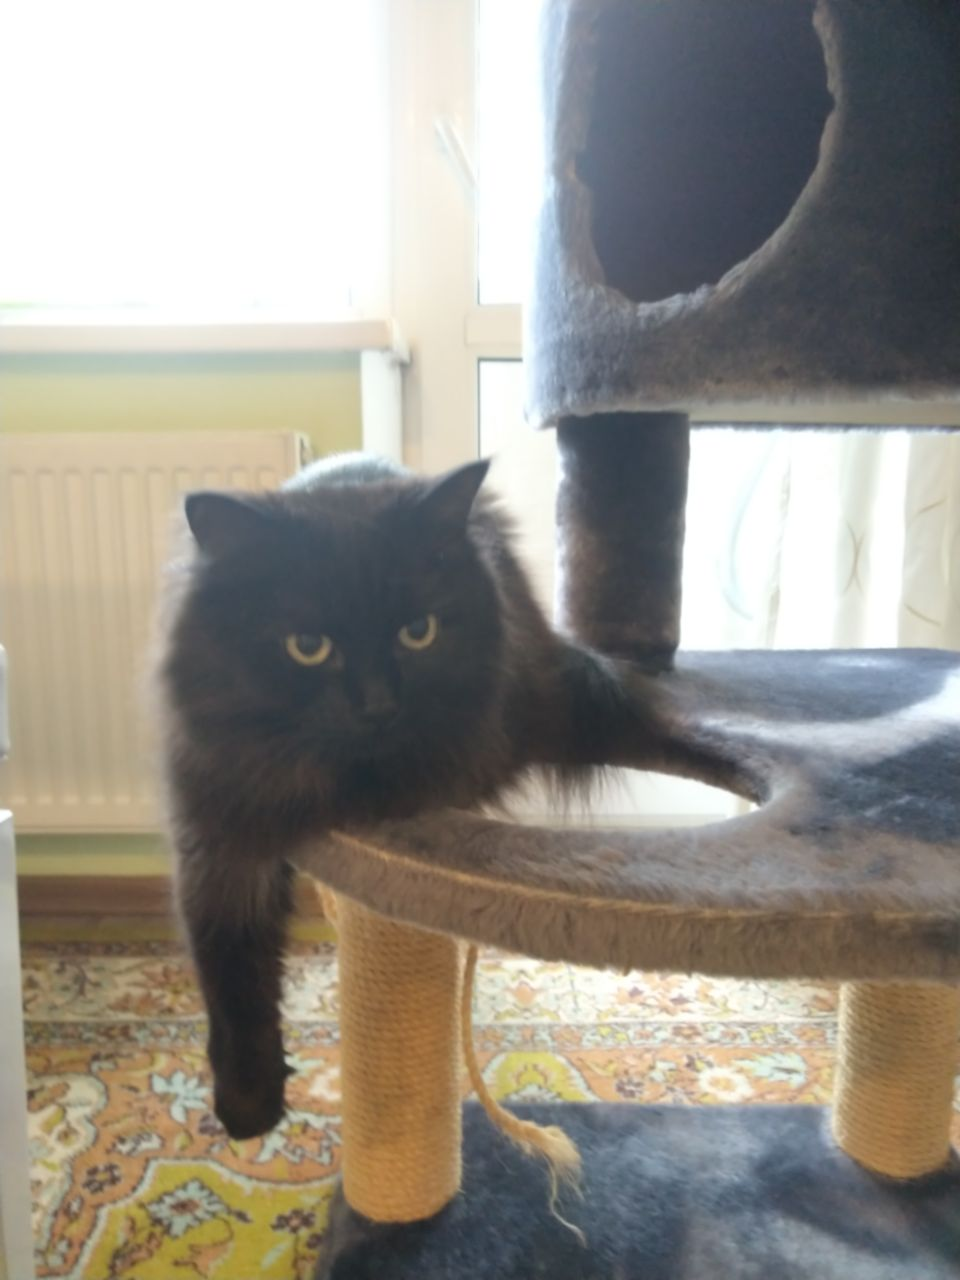

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Мыслей нет. Но интересно, конечно.

In [ ]:
pip freeze > requirements.txt